Modelo 1: LSTM

In [2]:
# Grid Search para o modelo LSTM

import numpy as np
import scipy.io as sio
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Definir os hiperparâmetros a serem testados
hyperparams_grid = {
    'sequence_length': [10, 20, 30, 40],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64]
}

# Carregar os dados
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

mat_data_temp = sio.loadmat(file_path_temp_coefs)
coefs = mat_data_temp['coefs']
phi = sio.loadmat(file_path_spatial_modes)['phi']
y_positions = sio.loadmat(file_path_mean_flow)['y'].flatten()
Xavg = sio.loadmat(file_path_mean_flow)['Xavg'].flatten()
nmodos_pod = sio.loadmat(file_path_parameters)['nmodes']

# Definir o número de coeficientes a serem utilizados
num_coefs = 20  # Usando 20 coeficientes
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Divisão dos dados
first_interval_end = 4801
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Normalização
num_total_coefs = num_coefs * 2
scalers = []

coefs_train = np.vstack([real_coefs_train, imag_coefs_train])
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])
coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = MinMaxScaler(feature_range=(-1, 1))
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

def create_sequences(real_coefs_norm, imag_coefs_norm, seq_length):
    X, y = [], []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])
        X.append(X_seq)
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])
        y.append(y_seq)
    X = np.array(X).transpose(0, 2, 1)
    y = np.array(y)
    return X, y

# Dicionário para armazenar os resultados
results = {}

# Loop pelos hiperparâmetros
from itertools import product

keys = hyperparams_grid.keys()
values = (hyperparams_grid[key] for key in keys)

total_combinations = np.prod([len(v) for v in hyperparams_grid.values()])
print(f"Total de combinações de hiperparâmetros: {total_combinations}")

combination_index = 1

for hp_values in product(*values):
    hyperparams = dict(zip(keys, hp_values))
    sequence_length = hyperparams['sequence_length']
    lstm_units = hyperparams['lstm_units']
    dropout_rate = hyperparams['dropout_rate']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']

    print(f"\nExecutando combinação {combination_index}/{total_combinations}: {hyperparams}")
    combination_index += 1

    # Criar sequências
    X_train, y_train = create_sequences(coefs_train_normalized[:num_coefs, :], coefs_train_normalized[num_coefs:, :], sequence_length)
    X_val, y_val = create_sequences(coefs_val_normalized[:num_coefs, :], coefs_val_normalized[num_coefs:, :], sequence_length)

    # Verificar se há dados suficientes
    if X_train.shape[0] == 0 or X_val.shape[0] == 0:
        print("Dados insuficientes para a sequência atual. Pulando para a próxima combinação.")
        continue

    # Definir o modelo
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_total_coefs))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Treinar o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early_stopping], verbose=0)

    # Previsões
    predictions_normalized = model.predict(X_val)
    predictions = np.zeros_like(predictions_normalized)
    y_val_original = np.zeros_like(y_val)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
        y_val_original[:, i] = scaler.inverse_transform(y_val[:, i].reshape(-1, 1)).flatten()

    # Separar as partes real e imaginária
    pred_real = predictions[:, :num_coefs]
    pred_imag = predictions[:, num_coefs:]
    actual_real = y_val_original[:, :num_coefs]
    actual_imag = y_val_original[:, num_coefs:]

    # Cálculo do NMSE
    actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
    predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)

    nmse_modulus = []
    for c in range(num_coefs):
        mse = mean_squared_error(actual_modulus[:, c], predicted_modulus[:, c])
        variance = np.var(actual_modulus[:, c])
        nmse = mse / variance if variance != 0 else np.nan
        nmse_modulus.append(nmse)

    average_nmse_modulus = np.nanmean(nmse_modulus)

    # Salvar resultados
    result_key = f"SeqLen:{sequence_length}_Units:{lstm_units}_Dropout:{dropout_rate}_LR:{learning_rate}_Batch:{batch_size}"
    results[result_key] = average_nmse_modulus
    print(f"NMSE médio do módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Salvar os resultados em um arquivo
import pickle
with open('grid_search_results_lstm.pkl', 'wb') as f:
    pickle.dump(results, f)

# Encontrar a melhor combinação de hiperparâmetros
best_params = min(results, key=results.get)
print(f"\nMelhores hiperparâmetros: {best_params} com NMSE: {results[best_params]:.6f}")


Número total de modos utilizados: 20
Total de combinações de hiperparâmetros: 216

Executando combinação 1/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.066097

Executando combinação 2/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.086316

Executando combinação 3/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.107740

Executando combinação 4/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.148129

Executando combinação 5/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NMSE médio do módulo dos coeficientes: 0.516602

Executando combinação 6/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NMSE médio do módulo dos coeficientes: 0.833468

Executando combinação 7/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NMSE médio do módulo dos coeficientes: 0.157242

Executando combinação 8/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NMSE médio do módulo dos coeficientes: 0.175968

Executando combinação 9/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NMSE médio do módulo dos coeficientes: 0.219286

Executando combinação 10/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
NMSE médio do módulo dos coeficientes: 0.301315

Executando combinação 11/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
NMSE médio do módulo dos coeficientes: 0.702677

Executando combinação 12/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
NMSE médio do módulo dos coeficientes: 1.105832

Executando combinação 13/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.308745

Executando combinação 14/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.354132

Executando combinação 15/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
NMSE médio do módulo dos coeficientes: 0.391724

Executando combinação 16/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
NMSE médio do módulo dos coeficientes: 0.483666

Executando combinação 17/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NMSE médio do módulo dos coeficientes: 0.918664

Executando combinação 18/216: {'sequence_length': 10, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 1.268355

Executando combinação 19/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.034415

Executando combinação 20/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.041582

Executando combinação 21/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.052703

Executando combinação 22/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
NMSE médio do módulo dos coeficientes: 0.070278

Executando combinação 23/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
NMSE médio do módulo dos coeficientes: 0.263986

Executando combinação 24/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.422014

Executando combinação 25/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
NMSE médio do módulo dos coeficientes: 0.062619

Executando combinação 26/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.071840

Executando combinação 27/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.085291

Executando combinação 28/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.109546

Executando combinação 29/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.380298

Executando combinação 30/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
NMSE médio do módulo dos coeficientes: 0.557025

Executando combinação 31/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.126571

Executando combinação 32/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
NMSE médio do módulo dos coeficientes: 0.171978

Executando combinação 33/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.192909

Executando combinação 34/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
NMSE médio do módulo dos coeficientes: 0.238538

Executando combinação 35/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.494553

Executando combinação 36/216: {'sequence_length': 10, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
NMSE médio do módulo dos coeficientes: 0.699389

Executando combinação 37/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.026517

Executando combinação 38/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
NMSE médio do módulo dos coeficientes: 0.030275

Executando combinação 39/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.034807

Executando combinação 40/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.046566

Executando combinação 41/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.142986

Executando combinação 42/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.238905

Executando combinação 43/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.035268

Executando combinação 44/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.039646

Executando combinação 45/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.046290

Executando combinação 46/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.059504

Executando combinação 47/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.194834

Executando combinação 48/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
NMSE médio do módulo dos coeficientes: 0.317396

Executando combinação 49/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
NMSE médio do módulo dos coeficientes: 0.053845

Executando combinação 50/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.064359

Executando combinação 51/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.067813

Executando combinação 52/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.089513

Executando combinação 53/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.280068

Executando combinação 54/216: {'sequence_length': 10, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.396355

Executando combinação 55/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
NMSE médio do módulo dos coeficientes: 0.064952

Executando combinação 56/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.092436

Executando combinação 57/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.104316

Executando combinação 58/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.169586

Executando combinação 59/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.498964

Executando combinação 60/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.805177

Executando combinação 61/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
NMSE médio do módulo dos coeficientes: 0.150439

Executando combinação 62/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
NMSE médio do módulo dos coeficientes: 0.179459

Executando combinação 63/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.231191

Executando combinação 64/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.313657

Executando combinação 65/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.696151

Executando combinação 66/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
NMSE médio do módulo dos coeficientes: 1.086040

Executando combinação 67/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
NMSE médio do módulo dos coeficientes: 0.307072

Executando combinação 68/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.359146

Executando combinação 69/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NMSE médio do módulo dos coeficientes: 0.388119

Executando combinação 70/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.487526

Executando combinação 71/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.912124

Executando combinação 72/216: {'sequence_length': 20, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 1.313628

Executando combinação 73/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
NMSE médio do módulo dos coeficientes: 0.032821

Executando combinação 74/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.043002

Executando combinação 75/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.053959

Executando combinação 76/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.082882

Executando combinação 77/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.270664

Executando combinação 78/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
NMSE médio do módulo dos coeficientes: 0.405996

Executando combinação 79/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.062516

Executando combinação 80/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
NMSE médio do módulo dos coeficientes: 0.077761

Executando combinação 81/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
NMSE médio do módulo dos coeficientes: 0.083049

Executando combinação 82/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.137722

Executando combinação 83/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.380407

Executando combinação 84/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.546135

Executando combinação 85/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.132092

Executando combinação 86/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.143945

Executando combinação 87/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.167416

Executando combinação 88/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.219146

Executando combinação 89/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
NMSE médio do módulo dos coeficientes: 0.510088

Executando combinação 90/216: {'sequence_length': 20, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.686094

Executando combinação 91/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
NMSE médio do módulo dos coeficientes: 0.022736

Executando combinação 92/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
NMSE médio do módulo dos coeficientes: 0.027423

Executando combinação 93/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
NMSE médio do módulo dos coeficientes: 0.034185

Executando combinação 94/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
NMSE médio do módulo dos coeficientes: 0.055144

Executando combinação 95/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
NMSE médio do módulo dos coeficientes: 0.165894

Executando combinação 96/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
NMSE médio do módulo dos coeficientes: 0.251672

Executando combinação 97/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
NMSE médio do módulo dos coeficientes: 0.032724

Executando combinação 98/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
NMSE médio do módulo dos coeficientes: 0.039016

Executando combinação 99/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
NMSE médio do módulo dos coeficientes: 0.044545

Executando combinação 100/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
NMSE médio do módulo dos coeficientes: 0.068589

Executando combinação 101/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
NMSE médio do módulo dos coeficientes: 0.228520

Executando combinação 102/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
NMSE médio do módulo dos coeficientes: 0.332351

Executando combinação 103/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
NMSE médio do módulo dos coeficientes: 0.051967

Executando combinação 104/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
NMSE médio do módulo dos coeficientes: 0.060507

Executando combinação 105/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
NMSE médio do módulo dos coeficientes: 0.067415

Executando combinação 106/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.092823

Executando combinação 107/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
NMSE médio do módulo dos coeficientes: 0.296166

Executando combinação 108/216: {'sequence_length': 20, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
NMSE médio do módulo dos coeficientes: 0.403933

Executando combinação 109/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.067447

Executando combinação 110/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
NMSE médio do módulo dos coeficientes: 0.093437

Executando combinação 111/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.103305

Executando combinação 112/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.186198

Executando combinação 113/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
NMSE médio do módulo dos coeficientes: 0.532647

Executando combinação 114/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.926159

Executando combinação 115/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.148199

Executando combinação 116/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.219986

Executando combinação 117/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
NMSE médio do módulo dos coeficientes: 0.236129

Executando combinação 118/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.337515

Executando combinação 119/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.707927

Executando combinação 120/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 1.139266

Executando combinação 121/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.310422

Executando combinação 122/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.380207

Executando combinação 123/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.400805

Executando combinação 124/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.519458

Executando combinação 125/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.912281

Executando combinação 126/216: {'sequence_length': 30, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 1.424228

Executando combinação 127/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.033998

Executando combinação 128/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.049388

Executando combinação 129/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.054590

Executando combinação 130/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
NMSE médio do módulo dos coeficientes: 0.101658

Executando combinação 131/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.292172

Executando combinação 132/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.476690

Executando combinação 133/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.062565

Executando combinação 134/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
NMSE médio do módulo dos coeficientes: 0.075359

Executando combinação 135/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
NMSE médio do módulo dos coeficientes: 0.090399

Executando combinação 136/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.145460

Executando combinação 137/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
NMSE médio do módulo dos coeficientes: 0.395683

Executando combinação 138/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.593616

Executando combinação 139/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
NMSE médio do módulo dos coeficientes: 0.123438

Executando combinação 140/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.176566

Executando combinação 141/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.198625

Executando combinação 142/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.267863

Executando combinação 143/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.512096

Executando combinação 144/216: {'sequence_length': 30, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.763716

Executando combinação 145/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step
NMSE médio do módulo dos coeficientes: 0.022395

Executando combinação 146/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
NMSE médio do módulo dos coeficientes: 0.032425

Executando combinação 147/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step
NMSE médio do módulo dos coeficientes: 0.037112

Executando combinação 148/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step
NMSE médio do módulo dos coeficientes: 0.072516

Executando combinação 149/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
NMSE médio do módulo dos coeficientes: 0.193440

Executando combinação 150/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
NMSE médio do módulo dos coeficientes: 0.295755

Executando combinação 151/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step
NMSE médio do módulo dos coeficientes: 0.035085

Executando combinação 152/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
NMSE médio do módulo dos coeficientes: 0.041291

Executando combinação 153/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
NMSE médio do módulo dos coeficientes: 0.046880

Executando combinação 154/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
NMSE médio do módulo dos coeficientes: 0.083926

Executando combinação 155/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
NMSE médio do módulo dos coeficientes: 0.243907

Executando combinação 156/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
NMSE médio do módulo dos coeficientes: 0.364755

Executando combinação 157/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
NMSE médio do módulo dos coeficientes: 0.054512

Executando combinação 158/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
NMSE médio do módulo dos coeficientes: 0.062833

Executando combinação 159/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
NMSE médio do módulo dos coeficientes: 0.072912

Executando combinação 160/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step
NMSE médio do módulo dos coeficientes: 0.119129

Executando combinação 161/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step
NMSE médio do módulo dos coeficientes: 0.309989

Executando combinação 162/216: {'sequence_length': 30, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step
NMSE médio do módulo dos coeficientes: 0.453335

Executando combinação 163/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
NMSE médio do módulo dos coeficientes: 0.068320

Executando combinação 164/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.089183

Executando combinação 165/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.098034

Executando combinação 166/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.169103

Executando combinação 167/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.487144

Executando combinação 168/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.817012

Executando combinação 169/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.161952

Executando combinação 170/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.178821

Executando combinação 171/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.215482

Executando combinação 172/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.312195

Executando combinação 173/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.691773

Executando combinação 174/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 1.060106

Executando combinação 175/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.309671

Executando combinação 176/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.361211

Executando combinação 177/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.393878

Executando combinação 178/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.487621

Executando combinação 179/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
NMSE médio do módulo dos coeficientes: 0.907981

Executando combinação 180/216: {'sequence_length': 40, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 1.272788

Executando combinação 181/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step
NMSE médio do módulo dos coeficientes: 0.033983

Executando combinação 182/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.045905

Executando combinação 183/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.057903

Executando combinação 184/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.097179

Executando combinação 185/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.290526

Executando combinação 186/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
NMSE médio do módulo dos coeficientes: 0.410993

Executando combinação 187/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.064780

Executando combinação 188/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.076140

Executando combinação 189/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.092792

Executando combinação 190/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.122463

Executando combinação 191/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
NMSE médio do módulo dos coeficientes: 0.385988

Executando combinação 192/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
NMSE médio do módulo dos coeficientes: 0.537274

Executando combinação 193/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.115335

Executando combinação 194/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.138633

Executando combinação 195/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.195678

Executando combinação 196/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
NMSE médio do módulo dos coeficientes: 0.225607

Executando combinação 197/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.506816

Executando combinação 198/216: {'sequence_length': 40, 'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.698723

Executando combinação 199/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step
NMSE médio do módulo dos coeficientes: 0.022821

Executando combinação 200/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step
NMSE médio do módulo dos coeficientes: 0.027786

Executando combinação 201/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step
NMSE médio do módulo dos coeficientes: 0.038942

Executando combinação 202/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
NMSE médio do módulo dos coeficientes: 0.067256

Executando combinação 203/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step
NMSE médio do módulo dos coeficientes: 0.190509

Executando combinação 204/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step
NMSE médio do módulo dos coeficientes: 0.272360

Executando combinação 205/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step
NMSE médio do módulo dos coeficientes: 0.034679

Executando combinação 206/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
NMSE médio do módulo dos coeficientes: 0.036655

Executando combinação 207/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step
NMSE médio do módulo dos coeficientes: 0.042786

Executando combinação 208/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step
NMSE médio do módulo dos coeficientes: 0.071234

Executando combinação 209/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step
NMSE médio do módulo dos coeficientes: 0.228903

Executando combinação 210/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step
NMSE médio do módulo dos coeficientes: 0.339439

Executando combinação 211/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step
NMSE médio do módulo dos coeficientes: 0.053849

Executando combinação 212/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step
NMSE médio do módulo dos coeficientes: 0.060899

Executando combinação 213/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step
NMSE médio do módulo dos coeficientes: 0.077309

Executando combinação 214/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step
NMSE médio do módulo dos coeficientes: 0.100958

Executando combinação 215/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step
NMSE médio do módulo dos coeficientes: 0.290559

Executando combinação 216/216: {'sequence_length': 40, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 64}


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step
NMSE médio do módulo dos coeficientes: 0.401519

Melhores hiperparâmetros: SeqLen:30_Units:256_Dropout:0.1_LR:0.001_Batch:32 com NMSE: 0.022395


Modelo 2: LSTM + CNN

In [6]:
# Grid Search Otimizado para o Modelo LSTM + CNN

import numpy as np
import scipy.io as sio
import os
import pickle
from itertools import product
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2  # Importação adicionada para 'l2'
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Definir os hiperparâmetros a serem testados
hyperparams_grid = {
    'sequence_length': [20, 30],                 # 2 opções
    'lstm_units': [64, 128],                     # 2 opções
    'dropout_rate': [0.1, 0.2],                  # 2 opções
    'learning_rate': [0.001, 0.0005],            # 2 opções
    'batch_size': [32, 64]                        # 2 opções
}

# Fixar parâmetros menos impactantes para reduzir combinações
fixed_hyperparams = {
    'conv_filters': [32, 16],                    # Fixado em duas camadas
    'kernel_size': [3]                            # Fixado
}

# Carregar os dados
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

# Verificar se os arquivos existem
for file_path in [file_path_temp_coefs, file_path_spatial_modes, file_path_mean_flow, file_path_parameters]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Arquivo {file_path} não encontrado. Verifique o caminho.")

# Carregar os dados dos arquivos .mat
mat_data_temp = sio.loadmat(file_path_temp_coefs)
coefs = mat_data_temp['coefs']
phi = sio.loadmat(file_path_spatial_modes)['phi']
y_positions = sio.loadmat(file_path_mean_flow)['y'].flatten()
Xavg = sio.loadmat(file_path_mean_flow)['Xavg'].flatten()
nmodos_pod = sio.loadmat(file_path_parameters)['nmodes']

# Definir o número de coeficientes a serem utilizados
num_coefs = 20  # Usando 20 coeficientes
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Divisão dos dados
first_interval_end = 4801
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Concatenar as partes real e imaginária para normalização
coefs_train = np.vstack([real_coefs_train, imag_coefs_train])  # Dimensão (num_coefs*2, N_train)
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])        # Dimensão (num_coefs*2, N_val)

# Normalização usando MinMaxScaler
num_total_coefs = num_coefs * 2
scalers = []

coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = MinMaxScaler(feature_range=(-1, 1))
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

# Função para criar sequências de entrada e saídas correspondentes (previsão de um passo à frente)
def create_sequences(real_coefs_norm, imag_coefs_norm, seq_length):
    X = []
    y = []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        # Sequências das partes real e imaginária
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])  # Dimensão (num_coefs*2, seq_length)
        X.append(X_seq)
        # Saídas: próximo coeficiente após a sequência
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])  # Dimensão (num_coefs*2,)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    # Ajustar as dimensões para [samples, timesteps, features]
    X = X.transpose(0, 2, 1)  # [samples, timesteps, features]
    return X, y

# Dicionário para armazenar os resultados
results = {}

# Gerar todas as combinações possíveis de hiperparâmetros
keys = hyperparams_grid.keys()
values = (hyperparams_grid[key] for key in keys)
total_combinations = np.prod([len(v) for v in hyperparams_grid.values()])
print(f"Total de combinações de hiperparâmetros: {total_combinations}")

combination_index = 1

for hp_values in product(*values):
    hyperparams = dict(zip(keys, hp_values))
    sequence_length = hyperparams['sequence_length']
    lstm_units = hyperparams['lstm_units']
    dropout_rate = hyperparams['dropout_rate']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    
    # Fixar os hiperparâmetros fixos (Conv1D)
    conv_filters = fixed_hyperparams['conv_filters']
    kernel_size = fixed_hyperparams['kernel_size'][0]  # Apenas uma opção

    print(f"\nExecutando combinação {combination_index}/{total_combinations}:")
    print(f"SeqLen: {sequence_length}, Units: {lstm_units}, Filters: {conv_filters}, Kernel: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
    combination_index += 1

    # Criar sequências
    X_train, y_train = create_sequences(coefs_train_normalized[:num_coefs, :], coefs_train_normalized[num_coefs:, :], sequence_length)
    X_val, y_val = create_sequences(coefs_val_normalized[:num_coefs, :], coefs_val_normalized[num_coefs:, :], sequence_length)

    # Verificar se há dados suficientes
    if X_train.shape[0] == 0 or X_val.shape[0] == 0:
        print("Dados insuficientes para a sequência atual. Pulando para a próxima combinação.")
        continue

    # Definir o modelo com CNN + LSTM e regularização L2
    lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = lstm_input
    x = Conv1D(filters=conv_filters[0], kernel_size=kernel_size, activation='relu', padding='same',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=conv_filters[1], kernel_size=kernel_size, activation='relu', padding='same',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units, return_sequences=False, activation='tanh',
             kernel_regularizer=l2(0.0001),
             recurrent_dropout=dropout_rate)(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_total_coefs, activation='linear', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Treinar o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early_stopping], verbose=0)

    # Previsões
    predictions_normalized = model.predict(X_val)
    predictions = np.zeros_like(predictions_normalized)
    y_val_original = np.zeros_like(y_val)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
        y_val_original[:, i] = scaler.inverse_transform(y_val[:, i].reshape(-1, 1)).flatten()

    # Separar as partes real e imaginária
    pred_real = predictions[:, :num_coefs]
    pred_imag = predictions[:, num_coefs:]
    actual_real = y_val_original[:, :num_coefs]
    actual_imag = y_val_original[:, num_coefs:]

    # Calcular o módulo dos coeficientes
    actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
    predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)

    # Função para calcular NMSE
    def calculate_normalized_mse(actual, predicted):
        num_coefs = actual.shape[1]
        nmse = np.zeros(num_coefs)
        for c in range(num_coefs):
            mse = mean_squared_error(actual[:, c], predicted[:, c])
            variance = np.var(actual[:, c])
            nmse[c] = mse / variance if variance != 0 else np.nan
        return nmse

    # Calcular NMSE para o módulo
    nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)

    # Calcular a média do NMSE, ignorando valores NaN
    average_nmse_modulus = np.nanmean(nmse_modulus)

    # Salvar resultados
    result_key = f"SeqLen:{sequence_length}_Units:{lstm_units}_Filters:{conv_filters}_Kernel:{kernel_size}_Dropout:{dropout_rate}_LR:{learning_rate}_Batch:{batch_size}"
    results[result_key] = average_nmse_modulus
    print(f"NMSE médio do módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Salvar os resultados em um arquivo
with open('grid_search_results_lstm_cnn.pkl', 'wb') as f:
    pickle.dump(results, f)

# Encontrar a melhor combinação de hiperparâmetros
best_params = min(results, key=results.get)
print(f"\nMelhores hiperparâmetros: {best_params} com NMSE: {results[best_params]:.6f}")


Número total de modos utilizados: 20
Total de combinações de hiperparâmetros: 32

Executando combinação 1/32:
SeqLen: 20, Units: 64, Filters: [32, 16], Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
NMSE médio do módulo dos coeficientes: 0.448197

Executando combinação 2/32:
SeqLen: 20, Units: 64, Filters: [32, 16], Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 64
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.569801

Executando combinação 3/32:
SeqLen: 20, Units: 64, Filters: [32, 16], Kernel: 3, Dropout: 0.1, LR: 0.0005, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.621619

Executando combinação 4/32:
SeqLen: 20, Units: 64, Filters: [32, 16], Kernel: 3, Dropout: 0.1, LR: 0.0005, Batch: 64
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.888308

Executando combinação 5/32:
SeqLen: 20, Units: 64, Filters: [32, 16], Kernel: 3, Dropout

In [8]:
# Grid Search Otimizado e Corrigido para o Modelo LSTM + CNN

import numpy as np
import scipy.io as sio
import os
import pickle
from itertools import product
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2  # Importação adicionada para 'l2'
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Definir os hiperparâmetros a serem testados
# Reduzimos o número de hiperparâmetros para acelerar o Grid Search
hyperparams_grid = {
    'sequence_length': [20, 30],                 # 2 opções
    'lstm_units': [64, 128],                     # 2 opções
    'dropout_rate': [0.1, 0.2],                  # 2 opções
    # Removemos 'learning_rate' e 'batch_size' da grade para fixá-los
}

# Fixar parâmetros menos impactantes para reduzir combinações
fixed_hyperparams = {
    'conv_filters': [32, 16],                    # 2 opções para filtros Conv1D
    'kernel_size': [3],                           # Fixado em 3
    'learning_rate': [0.001],                     # Fixado em 0.001
    'batch_size': [32]                             # Fixado em 32
}

# Carregar os dados
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

# Verificar se os arquivos existem
for file_path in [file_path_temp_coefs, file_path_spatial_modes, file_path_mean_flow, file_path_parameters]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Arquivo {file_path} não encontrado. Verifique o caminho.")

# Carregar os dados dos arquivos .mat
mat_data_temp = sio.loadmat(file_path_temp_coefs)
coefs = mat_data_temp['coefs']
phi = sio.loadmat(file_path_spatial_modes)['phi']
y_positions = sio.loadmat(file_path_mean_flow)['y'].flatten()
Xavg = sio.loadmat(file_path_mean_flow)['Xavg'].flatten()
nmodos_pod = sio.loadmat(file_path_parameters)['nmodes']

# Definir o número de coeficientes a serem utilizados
num_coefs = 20  # Usando 20 coeficientes
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Divisão dos dados
first_interval_end = 4801
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Concatenar as partes real e imaginária para normalização
coefs_train = np.vstack([real_coefs_train, imag_coefs_train])  # Dimensão (num_coefs*2, N_train)
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])        # Dimensão (num_coefs*2, N_val)

# Normalização usando MinMaxScaler
num_total_coefs = num_coefs * 2
scalers = []

coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = MinMaxScaler(feature_range=(-1, 1))
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

# Função para criar sequências de entrada e saídas correspondentes (previsão de um passo à frente)
def create_sequences(real_coefs_norm, imag_coefs_norm, seq_length):
    X = []
    y = []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        # Sequências das partes real e imaginária
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])  # Dimensão (num_coefs*2, seq_length)
        X.append(X_seq)
        # Saídas: próximo coeficiente após a sequência
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])  # Dimensão (num_coefs*2,)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    # Ajustar as dimensões para [samples, timesteps, features]
    X = X.transpose(0, 2, 1)  # [samples, timesteps, features]
    return X, y

# Dicionário para armazenar os resultados
results = {}

# Gerar todas as combinações possíveis de hiperparâmetros (reduzido para 2^5 = 32)
keys = list(hyperparams_grid.keys()) + list(fixed_hyperparams.keys())
values = [hyperparams_grid[key] for key in hyperparams_grid.keys()] + [fixed_hyperparams[key] for key in fixed_hyperparams.keys()]
total_combinations = np.prod([len(v) for v in values])
print(f"Total de combinações de hiperparâmetros: {total_combinations}")

combination_index = 1

for hp_values in product(*values):
    hyperparams = dict(zip(keys, hp_values))
    sequence_length = hyperparams['sequence_length']
    lstm_units = hyperparams['lstm_units']
    dropout_rate = hyperparams['dropout_rate']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    conv_filters = hyperparams['conv_filters']
    kernel_size = hyperparams['kernel_size']
    
    print(f"\nExecutando combinação {combination_index}/{total_combinations}:")
    print(f"SeqLen: {sequence_length}, Units: {lstm_units}, Filters: {conv_filters}, Kernel: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
    combination_index += 1

    # Criar sequências
    X_train, y_train = create_sequences(coefs_train_normalized[:num_coefs, :], coefs_train_normalized[num_coefs:, :], sequence_length)
    X_val, y_val = create_sequences(coefs_val_normalized[:num_coefs, :], coefs_val_normalized[num_coefs:, :], sequence_length)

    # Verificar se há dados suficientes
    if X_train.shape[0] == 0 or X_val.shape[0] == 0:
        print("Dados insuficientes para a sequência atual. Pulando para a próxima combinação.")
        continue

    # Definir o modelo com uma única camada Conv1D + LSTM e regularização L2
    lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = lstm_input
    # Correção: Usar conv_filters diretamente, já que é um inteiro
    x = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units, return_sequences=False, activation='tanh',
             kernel_regularizer=l2(0.0001),
             recurrent_dropout=dropout_rate)(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_total_coefs, activation='linear', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Treinar o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early_stopping], verbose=0)

    # Previsões
    predictions_normalized = model.predict(X_val)
    predictions = np.zeros_like(predictions_normalized)
    y_val_original = np.zeros_like(y_val)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
        y_val_original[:, i] = scaler.inverse_transform(y_val[:, i].reshape(-1, 1)).flatten()

    # Separar as partes real e imaginária
    pred_real = predictions[:, :num_coefs]
    pred_imag = predictions[:, num_coefs:]
    actual_real = y_val_original[:, :num_coefs]
    actual_imag = y_val_original[:, num_coefs:]

    # Calcular o módulo dos coeficientes
    actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
    predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)

    # Função para calcular NMSE
    def calculate_normalized_mse(actual, predicted):
        num_coefs = actual.shape[1]
        nmse = np.zeros(num_coefs)
        for c in range(num_coefs):
            mse = mean_squared_error(actual[:, c], predicted[:, c])
            variance = np.var(actual[:, c])
            nmse[c] = mse / variance if variance != 0 else np.nan
        return nmse

    # Calcular NMSE para o módulo
    nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)

    # Calcular a média do NMSE, ignorando valores NaN
    average_nmse_modulus = np.nanmean(nmse_modulus)

    # Salvar resultados
    result_key = f"SeqLen:{sequence_length}_Units:{lstm_units}_Filters:{conv_filters}_Kernel:{kernel_size}_Dropout:{dropout_rate}_LR:{learning_rate}_Batch:{batch_size}"
    results[result_key] = average_nmse_modulus
    print(f"NMSE médio do módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Salvar os resultados em um arquivo
with open('grid_search_results_lstm_cnn.pkl', 'wb') as f:
    pickle.dump(results, f)

# Encontrar a melhor combinação de hiperparâmetros
best_params = min(results, key=results.get)
print(f"\nMelhores hiperparâmetros: {best_params} com NMSE: {results[best_params]:.6f}")


Número total de modos utilizados: 20
Total de combinações de hiperparâmetros: 16

Executando combinação 1/16:
SeqLen: 20, Units: 64, Filters: 32, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
NMSE médio do módulo dos coeficientes: 0.360347

Executando combinação 2/16:
SeqLen: 20, Units: 64, Filters: 16, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 0.667559

Executando combinação 3/16:
SeqLen: 20, Units: 64, Filters: 32, Kernel: 3, Dropout: 0.2, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
NMSE médio do módulo dos coeficientes: 0.616240

Executando combinação 4/16:
SeqLen: 20, Units: 64, Filters: 16, Kernel: 3, Dropout: 0.2, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
NMSE médio do módulo dos coeficientes: 1.113294

Executando combinação 5/16:
SeqLen: 20, Units: 128, Filters: 32, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175

In [9]:
# Grid Search Otimizado e Corrigido para o Modelo LSTM + CNN com Melhorias na Arquitetura

import numpy as np
import scipy.io as sio
import os
import pickle
from itertools import product
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Definir os hiperparâmetros a serem testados
hyperparams_grid = {
    'sequence_length': [20, 30],                 # 2 opções
    'lstm_units': [64, 128],                     # 2 opções
    'dropout_rate': [0.1, 0.2],                  # 2 opções
}

# Fixar parâmetros menos impactantes para reduzir combinações
fixed_hyperparams = {
    'conv_filters': [32, 16],                    # 2 opções para filtros Conv1D
    'kernel_size': [3],                           # Fixado em 3
    'learning_rate': [0.001],                     # Fixado em 0.001
    'batch_size': [32]                             # Fixado em 32
}

# Carregar os dados
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

# Verificar se os arquivos existem
for file_path in [file_path_temp_coefs, file_path_spatial_modes, file_path_mean_flow, file_path_parameters]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Arquivo {file_path} não encontrado. Verifique o caminho.")

# Carregar os dados dos arquivos .mat
mat_data_temp = sio.loadmat(file_path_temp_coefs)
coefs = mat_data_temp['coefs']
phi = sio.loadmat(file_path_spatial_modes)['phi']
y_positions = sio.loadmat(file_path_mean_flow)['y'].flatten()
Xavg = sio.loadmat(file_path_mean_flow)['Xavg'].flatten()
nmodos_pod = sio.loadmat(file_path_parameters)['nmodes']

# Definir o número de coeficientes a serem utilizados
num_coefs = 20  # Usando 20 coeficientes
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Divisão dos dados
first_interval_end = 4801
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Concatenar as partes real e imaginária para normalização
coefs_train = np.vstack([real_coefs_train, imag_coefs_train])  # Dimensão (num_coefs*2, N_train)
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])        # Dimensão (num_coefs*2, N_val)

# Normalização usando StandardScaler
num_total_coefs = num_coefs * 2
scalers = []

coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = StandardScaler()
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

# Função para criar sequências de entrada e saídas correspondentes (previsão de um passo à frente)
def create_sequences(real_coefs_norm, imag_coefs_norm, seq_length):
    X = []
    y = []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        # Sequências das partes real e imaginária
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])  # Dimensão (num_coefs*2, seq_length)
        X.append(X_seq)
        # Saídas: próximo coeficiente após a sequência
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])  # Dimensão (num_coefs*2,)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    # Ajustar as dimensões para [samples, timesteps, features]
    X = X.transpose(0, 2, 1)  # [samples, timesteps, features]
    return X, y

# Dicionário para armazenar os resultados
results = {}

# Gerar todas as combinações possíveis de hiperparâmetros
keys = list(hyperparams_grid.keys()) + list(fixed_hyperparams.keys())
values = [hyperparams_grid[key] for key in hyperparams_grid.keys()] + [fixed_hyperparams[key] for key in fixed_hyperparams.keys()]
total_combinations = np.prod([len(v) for v in values])
print(f"Total de combinações de hiperparâmetros: {total_combinations}")

combination_index = 1

for hp_values in product(*values):
    hyperparams = dict(zip(keys, hp_values))
    sequence_length = hyperparams['sequence_length']
    lstm_units = hyperparams['lstm_units']
    dropout_rate = hyperparams['dropout_rate']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    conv_filters = hyperparams['conv_filters']
    kernel_size = hyperparams['kernel_size']
    
    print(f"\nExecutando combinação {combination_index}/{total_combinations}:")
    print(f"SeqLen: {sequence_length}, Units: {lstm_units}, Filters: {conv_filters}, Kernel: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
    combination_index += 1

    # Criar sequências
    X_train, y_train = create_sequences(coefs_train_normalized[:num_coefs, :], coefs_train_normalized[num_coefs:, :], sequence_length)
    X_val, y_val = create_sequences(coefs_val_normalized[:num_coefs, :], coefs_val_normalized[num_coefs:, :], sequence_length)

    # Verificar se há dados suficientes
    if X_train.shape[0] == 0 or X_val.shape[0] == 0:
        print("Dados insuficientes para a sequência atual. Pulando para a próxima combinação.")
        continue

    # Definir o modelo com uma única camada Conv1D + LSTM e regularização L2
    lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = lstm_input
    # Usar conv_filters diretamente, já que é um inteiro
    x = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units, return_sequences=False, activation='tanh',
             kernel_regularizer=l2(0.0001),
             recurrent_dropout=dropout_rate)(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_total_coefs, activation='linear', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Implementar Learning Rate Scheduler
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=3, min_lr=1e-6)

    # Treinar o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr], verbose=0)

    # Previsões
    predictions_normalized = model.predict(X_val)
    predictions = np.zeros_like(predictions_normalized)
    y_val_original = np.zeros_like(y_val)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
        y_val_original[:, i] = scaler.inverse_transform(y_val[:, i].reshape(-1, 1)).flatten()

    # Separar as partes real e imaginária
    pred_real = predictions[:, :num_coefs]
    pred_imag = predictions[:, num_coefs:]
    actual_real = y_val_original[:, :num_coefs]
    actual_imag = y_val_original[:, num_coefs:]

    # Calcular o módulo dos coeficientes
    actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
    predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)

    # Função para calcular NMSE
    def calculate_normalized_mse(actual, predicted):
        num_coefs = actual.shape[1]
        nmse = np.zeros(num_coefs)
        for c in range(num_coefs):
            mse = mean_squared_error(actual[:, c], predicted[:, c])
            variance = np.var(actual[:, c])
            nmse[c] = mse / variance if variance != 0 else np.nan
        return nmse

    # Calcular NMSE para o módulo
    nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)

    # Calcular a média do NMSE, ignorando valores NaN
    average_nmse_modulus = np.nanmean(nmse_modulus)

    # Salvar resultados
    result_key = f"SeqLen:{sequence_length}_Units:{lstm_units}_Filters:{conv_filters}_Kernel:{kernel_size}_Dropout:{dropout_rate}_LR:{learning_rate}_Batch:{batch_size}"
    results[result_key] = average_nmse_modulus
    print(f"NMSE médio do módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Salvar os resultados em um arquivo
with open('grid_search_results_lstm_cnn.pkl', 'wb') as f:
    pickle.dump(results, f)

# Encontrar a melhor combinação de hiperparâmetros
best_params = min(results, key=results.get)
print(f"\nMelhores hiperparâmetros: {best_params} com NMSE: {results[best_params]:.6f}")

# Carregar e Analisar os Resultados
with open('grid_search_results_lstm_cnn.pkl', 'rb') as f:
    results = pickle.load(f)

# Ordenar as combinações pelo NMSE em ordem crescente
sorted_results = sorted(results.items(), key=lambda x: x[1])

# Exibir as 3 melhores combinações
print("\nTop 3 combinações de hiperparâmetros com menor NMSE:")
for combo, nmse in sorted_results[:3]:
    print(f"{combo} => NMSE: {nmse:.6f}")

# Plotar as curvas de perda da melhor combinação
best_key = best_params
# Supondo que você tenha armazenado o histórico de treinamento, caso contrário, você precisará reexecutar o treinamento com a melhor combinação e salvar o histórico.
# Aqui, apenas exemplifico como plotar (substitua 'history' pelo histórico real do melhor modelo)
# plt.figure(figsize=(10,6))
# plt.plot(history.history['loss'], label='Loss Treinamento')
# plt.plot(history.history['val_loss'], label='Loss Validação')
# plt.xlabel('Épocas')
# plt.ylabel('Loss')
# plt.title('Curvas de Perda de Treinamento e Validação')
# plt.legend()
# plt.show()


Número total de modos utilizados: 20
Total de combinações de hiperparâmetros: 16

Executando combinação 1/16:
SeqLen: 20, Units: 64, Filters: 32, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
NMSE médio do módulo dos coeficientes: 0.401194

Executando combinação 2/16:
SeqLen: 20, Units: 64, Filters: 16, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
NMSE médio do módulo dos coeficientes: 0.809385

Executando combinação 3/16:
SeqLen: 20, Units: 64, Filters: 32, Kernel: 3, Dropout: 0.2, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NMSE médio do módulo dos coeficientes: 0.648186

Executando combinação 4/16:
SeqLen: 20, Units: 64, Filters: 16, Kernel: 3, Dropout: 0.2, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
NMSE médio do módulo dos coeficientes: 1.165509

Executando combinação 5/16:
SeqLen: 20, Units: 128, Filters: 32, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/

Número total de modos utilizados: 20
Total de combinações de hiperparâmetros: 16

Executando combinação 1/16:
SeqLen: 20, Units: 64, Filters: 32, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
NMSE médio do módulo dos coeficientes: 0.396521

Executando combinação 2/16:
SeqLen: 20, Units: 64, Filters: 16, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
NMSE médio do módulo dos coeficientes: 0.803682

Executando combinação 3/16:
SeqLen: 20, Units: 64, Filters: 32, Kernel: 3, Dropout: 0.2, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 0.667008

Executando combinação 4/16:
SeqLen: 20, Units: 64, Filters: 16, Kernel: 3, Dropout: 0.2, LR: 0.001, Batch: 32
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
NMSE médio do módulo dos coeficientes: 1.146012

Executando combinação 5/16:
SeqLen: 20, Units: 128, Filters: 32, Kernel: 3, Dropout: 0.1, LR: 0.001, Batch: 32
175

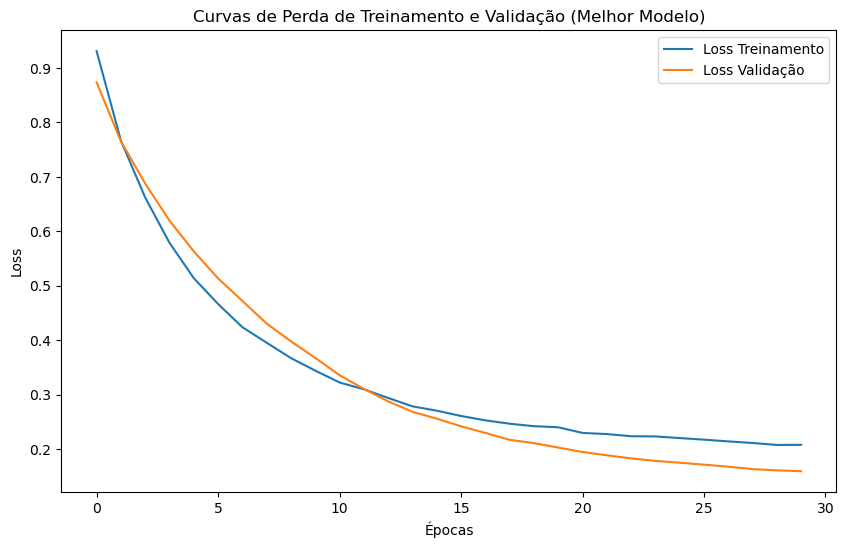

In [10]:
# Grid Search Otimizado e Corrigido para o Modelo LSTM + CNN (Uma Camada Conv1D)

import numpy as np
import scipy.io as sio
import os
import pickle
from itertools import product
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Definir os hiperparâmetros a serem testados
hyperparams_grid = {
    'sequence_length': [20, 30],                 # 2 opções
    'lstm_units': [64, 128],                     # 2 opções
    'dropout_rate': [0.1, 0.2],                  # 2 opções
}

# Fixar parâmetros menos impactantes para reduzir combinações
fixed_hyperparams = {
    'conv_filters': [32, 16],                    # 2 opções para filtros Conv1D
    'kernel_size': [3],                           # Fixado em 3
    'learning_rate': [0.001],                     # Fixado em 0.001
    'batch_size': [32]                             # Fixado em 32
}

# Carregar os dados
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

# Verificar se os arquivos existem
for file_path in [file_path_temp_coefs, file_path_spatial_modes, file_path_mean_flow, file_path_parameters]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Arquivo {file_path} não encontrado. Verifique o caminho.")

# Carregar os dados dos arquivos .mat
mat_data_temp = sio.loadmat(file_path_temp_coefs)
coefs = mat_data_temp['coefs']
phi = sio.loadmat(file_path_spatial_modes)['phi']
y_positions = sio.loadmat(file_path_mean_flow)['y'].flatten()
Xavg = sio.loadmat(file_path_mean_flow)['Xavg'].flatten()
nmodos_pod = sio.loadmat(file_path_parameters)['nmodes']

# Definir o número de coeficientes a serem utilizados
num_coefs = 20  # Usando 20 coeficientes
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Divisão dos dados
first_interval_end = 4801
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Concatenar as partes real e imaginária para normalização
coefs_train = np.vstack([real_coefs_train, imag_coefs_train])  # Dimensão (num_coefs*2, N_train)
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])        # Dimensão (num_coefs*2, N_val)

# Normalização usando StandardScaler
num_total_coefs = num_coefs * 2
scalers = []

coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = StandardScaler()
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

# Função para criar sequências de entrada e saídas correspondentes (previsão de um passo à frente)
def create_sequences(real_coefs_norm, imag_coefs_norm, seq_length):
    X = []
    y = []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        # Sequências das partes real e imaginária
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])  # Dimensão (num_coefs*2, seq_length)
        X.append(X_seq)
        # Saídas: próximo coeficiente após a sequência
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])  # Dimensão (num_coefs*2,)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    # Ajustar as dimensões para [samples, timesteps, features]
    X = X.transpose(0, 2, 1)  # [samples, timesteps, features]
    return X, y

# Dicionário para armazenar os resultados
results = {}

# Gerar todas as combinações possíveis de hiperparâmetros
keys = list(hyperparams_grid.keys()) + list(fixed_hyperparams.keys())
values = [hyperparams_grid[key] for key in hyperparams_grid.keys()] + [fixed_hyperparams[key] for key in fixed_hyperparams.keys()]
total_combinations = np.prod([len(v) for v in values])
print(f"Total de combinações de hiperparâmetros: {total_combinations}")

combination_index = 1

for hp_values in product(*values):
    hyperparams = dict(zip(keys, hp_values))
    sequence_length = hyperparams['sequence_length']
    lstm_units = hyperparams['lstm_units']
    dropout_rate = hyperparams['dropout_rate']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    conv_filters = hyperparams['conv_filters']
    kernel_size = hyperparams['kernel_size']
    
    print(f"\nExecutando combinação {combination_index}/{total_combinations}:")
    print(f"SeqLen: {sequence_length}, Units: {lstm_units}, Filters: {conv_filters}, Kernel: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
    combination_index += 1

    # Criar sequências
    X_train, y_train = create_sequences(coefs_train_normalized[:num_coefs, :], coefs_train_normalized[num_coefs:, :], sequence_length)
    X_val, y_val = create_sequences(coefs_val_normalized[:num_coefs, :], coefs_val_normalized[num_coefs:, :], sequence_length)

    # Verificar se há dados suficientes
    if X_train.shape[0] == 0 or X_val.shape[0] == 0:
        print("Dados insuficientes para a sequência atual. Pulando para a próxima combinação.")
        continue

    # Definir o modelo com uma única camada Conv1D + LSTM e regularização L2
    lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = lstm_input
    # Usar conv_filters diretamente, já que é um inteiro
    x = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units, return_sequences=False, activation='tanh',
             kernel_regularizer=l2(0.0001),
             recurrent_dropout=dropout_rate)(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_total_coefs, activation='linear', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Implementar Learning Rate Scheduler
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=3, min_lr=1e-6)

    # Treinar o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr], verbose=0)

    # Previsões
    predictions_normalized = model.predict(X_val)
    predictions = np.zeros_like(predictions_normalized)
    y_val_original = np.zeros_like(y_val)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
        y_val_original[:, i] = scaler.inverse_transform(y_val[:, i].reshape(-1, 1)).flatten()

    # Separar as partes real e imaginária
    pred_real = predictions[:, :num_coefs]
    pred_imag = predictions[:, num_coefs:]
    actual_real = y_val_original[:, :num_coefs]
    actual_imag = y_val_original[:, num_coefs:]

    # Calcular o módulo dos coeficientes
    actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
    predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)

    # Função para calcular NMSE
    def calculate_normalized_mse(actual, predicted):
        num_coefs = actual.shape[1]
        nmse = np.zeros(num_coefs)
        for c in range(num_coefs):
            mse = mean_squared_error(actual[:, c], predicted[:, c])
            variance = np.var(actual[:, c])
            nmse[c] = mse / variance if variance != 0 else np.nan
        return nmse

    # Calcular NMSE para o módulo
    nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)

    # Calcular a média do NMSE, ignorando valores NaN
    average_nmse_modulus = np.nanmean(nmse_modulus)

    # Salvar resultados
    result_key = f"SeqLen:{sequence_length}_Units:{lstm_units}_Filters:{conv_filters}_Kernel:{kernel_size}_Dropout:{dropout_rate}_LR:{learning_rate}_Batch:{batch_size}"
    results[result_key] = average_nmse_modulus
    print(f"NMSE médio do módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Salvar os resultados em um arquivo
with open('grid_search_results_lstm_cnn_one_conv_layer.pkl', 'wb') as f:
    pickle.dump(results, f)

# Encontrar a melhor combinação de hiperparâmetros
best_params = min(results, key=results.get)
print(f"\nMelhores hiperparâmetros: {best_params} com NMSE: {results[best_params]:.6f}")

# Carregar e Analisar os Resultados
with open('grid_search_results_lstm_cnn_one_conv_layer.pkl', 'rb') as f:
    results = pickle.load(f)

# Ordenar as combinações pelo NMSE em ordem crescente
sorted_results = sorted(results.items(), key=lambda x: x[1])

# Exibir as 3 melhores combinações
print("\nTop 3 combinações de hiperparâmetros com menor NMSE:")
for combo, nmse in sorted_results[:3]:
    print(f"{combo} => NMSE: {nmse:.6f}")

# Plotar as curvas de perda da melhor combinação
# Para isso, você precisará armazenar o histórico de treinamento (history) durante o Grid Search
# Uma abordagem é salvar o histórico para cada combinação, mas isso aumentaria o uso de memória
# Alternativamente, você pode re-treinar o modelo com a melhor combinação e salvar o histórico

# Exemplo de como re-treinar o melhor modelo e plotar as curvas de perda:
best_hyperparams = best_params.split("_")
best_hyperparams_dict = {}
for param in best_hyperparams:
    key, value = param.split(":")
    if key == "Filters":
        value = int(value)
    elif key in ["SeqLen", "Units", "Kernel", "Batch"]:
        value = int(value)
    elif key == "Dropout":
        value = float(value)
    elif key == "LR":
        value = float(value)
    best_hyperparams_dict[key] = value

sequence_length = best_hyperparams_dict['SeqLen']
lstm_units = best_hyperparams_dict['Units']
conv_filters = best_hyperparams_dict['Filters']
kernel_size = best_hyperparams_dict['Kernel']
dropout_rate = best_hyperparams_dict['Dropout']
learning_rate = best_hyperparams_dict['LR']
batch_size = best_hyperparams_dict['Batch']

# Criar sequências para o melhor modelo
X_train_best, y_train_best = create_sequences(coefs_train_normalized[:num_coefs, :], coefs_train_normalized[num_coefs:, :], sequence_length)
X_val_best, y_val_best = create_sequences(coefs_val_normalized[:num_coefs, :], coefs_val_normalized[num_coefs:, :], sequence_length)

# Definir o modelo com uma única camada Conv1D + LSTM
lstm_input = Input(shape=(X_train_best.shape[1], X_train_best.shape[2]))
x = lstm_input
x = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = LSTM(lstm_units, return_sequences=False, activation='tanh',
         kernel_regularizer=l2(0.0001),
         recurrent_dropout=dropout_rate)(x)
x = Dropout(dropout_rate)(x)
output = Dense(num_total_coefs, activation='linear', kernel_regularizer=l2(0.0001))(x)
model_best = Model(inputs=lstm_input, outputs=output)
model_best.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Implementar Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=1e-6)

# Treinar o melhor modelo e salvar o histórico
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_best = model_best.fit(X_train_best, y_train_best, epochs=30, batch_size=batch_size, validation_data=(X_val_best, y_val_best),
                              callbacks=[early_stopping, reduce_lr], verbose=1)

# Plotar as curvas de perda
plt.figure(figsize=(10,6))
plt.plot(history_best.history['loss'], label='Loss Treinamento')
plt.plot(history_best.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curvas de Perda de Treinamento e Validação (Melhor Modelo)')
plt.legend()
plt.show()


In [3]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import pickle
from itertools import product
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Definir os hiperparâmetros para o Grid Search
hyperparams_grid = {
    'sequence_length': [20, 30],        # 2 opções
    'lstm_units': [128, 256],           # 2 opções
    'conv_filters': [32, 64],           # 2 opções
    'dropout_rate': [0.2, 0.3],         # 2 opções
    'learning_rate': [0.001, 0.0005],   # 2 opções
    'l2_regularization': [0.0001]       # 1 opção (fixo)
}

# Caminho para salvar os resultados da busca em grade
results_path = 'grid_search_results_cnn_lstm.pkl'

# Diretório para salvar os modelos treinados
models_dir = 'trained_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Carregar os arquivos .mat fornecidos
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

# Carregar os coeficientes temporais
mat_data_temp = sio.loadmat(file_path_temp_coefs)
ts = mat_data_temp['ts'].flatten()  # Vetor de tempo
coefs = mat_data_temp['coefs']      # Matriz de coeficientes complexos

# Carregar os modos espaciais
mat_data_spatial = sio.loadmat(file_path_spatial_modes)
phi = mat_data_spatial['phi']       # Matriz de modos espaciais

# Carregar o vetor y e a média Xavg
mat_data_mean_flow = sio.loadmat(file_path_mean_flow)
y_positions = mat_data_mean_flow['y'].flatten()  # Vetor de posições espaciais y
Xavg = mat_data_mean_flow['Xavg'].flatten()      # Média do fluxo

# Carregar os modos usados no POD
mat_data_parameters = sio.loadmat(file_path_parameters)
nmodos_pod = mat_data_parameters['nmodes']       # Modos usados no POD

# Definir o número de coeficientes a serem utilizados
num_coefs = 20  # Atualizado para 20
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Definir o limite do primeiro intervalo
first_interval_end = 4801  # Posição correspondente ao tempo 1300

# Subamostragem do primeiro intervalo para taxa de 0.5 (pegando a cada 2 pontos)
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]

# Segundo intervalo (já na taxa de 0.5)
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Concatenar as partes real e imaginária para normalização
coefs_train = np.vstack([real_coefs_train, imag_coefs_train])  # Dimensão (num_coefs*2, N_train)
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])        # Dimensão (num_coefs*2, N_val)

# Normalizar os dados de treinamento individualmente para cada coeficiente usando MinMaxScaler
num_total_coefs = num_coefs * 2
scalers = []

coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = MinMaxScaler(feature_range=(-1, 1))
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

# Separar novamente as partes real e imaginária normalizadas
real_coefs_train_normalized = coefs_train_normalized[:num_coefs, :]
imag_coefs_train_normalized = coefs_train_normalized[num_coefs:, :]
real_coefs_val_normalized = coefs_val_normalized[:num_coefs, :]
imag_coefs_val_normalized = coefs_val_normalized[num_coefs:, :]

# Função para criar sequências de entrada e saídas correspondentes (previsão de um passo à frente)
def create_sequences_variable(real_coefs_norm, imag_coefs_norm, seq_length):
    X = []
    y = []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        # Sequências das partes real e imaginária
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])  # Dimensão (num_coefs*2, seq_length)
        X.append(X_seq)
        # Saídas: próximo coeficiente após a sequência
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])  # Dimensão (num_coefs*2,)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    # Ajustar as dimensões para [samples, timesteps, features]
    X = X.transpose(0, 2, 1)  # [samples, timesteps, features]
    return X, y

# Inicializar dicionário para armazenar resultados
results = {}

# Gerar todas as combinações possíveis de hiperparâmetros
keys = list(hyperparams_grid.keys())
values = [hyperparams_grid[key] for key in keys]

total_combinations = np.prod([len(v) for v in values])
print(f"Total de combinações de hiperparâmetros: {total_combinations}")

combination_index = 1

for hp_values in product(*values):
    hyperparams_current = dict(zip(keys, hp_values))
    sequence_length = hyperparams_current['sequence_length']
    lstm_units = hyperparams_current['lstm_units']
    conv_filters = hyperparams_current['conv_filters']
    dropout_rate = hyperparams_current['dropout_rate']
    learning_rate = hyperparams_current['learning_rate']
    l2_reg = hyperparams_current['l2_regularization']  # Incluído na grade
    
    # Gerar um nome único para a combinação de hiperparâmetros
    combo_name = f"SeqLen{sequence_length}_Units{lstm_units}_ConvFilt{conv_filters}_Dropout{dropout_rate}_LR{learning_rate}_L2Reg{l2_reg}"
    model_filename = f"{combo_name}.keras"
    model_filepath = os.path.join(models_dir, model_filename)
    
    print(f"\nExecutando combinação {combination_index}/{total_combinations}:")
    print(f"SeqLen: {sequence_length}, Units: {lstm_units}, Conv Filters: {conv_filters}, Dropout: {dropout_rate}, LR: {learning_rate}, L2 Reg: {l2_reg}")
    combination_index += 1
    
    # Verificar se o modelo já foi treinado e salvo
    if os.path.exists(model_filepath):
        print(f"Modelo para a combinação {combo_name} já existe. Pulando treinamento.")
        # Carregar o modelo salvo
        best_model = load_model(model_filepath)
    else:
        # Criar sequências para a combinação atual
        X_train_current, y_train_current = create_sequences_variable(real_coefs_train_normalized, imag_coefs_train_normalized, sequence_length)
        X_val_current, y_val_current = create_sequences_variable(real_coefs_val_normalized, imag_coefs_val_normalized, sequence_length)
        
        # Verificar se há dados suficientes
        if X_train_current.shape[0] == 0 or X_val_current.shape[0] == 0:
            print("Dados insuficientes para a sequência atual. Pulando para a próxima combinação.")
            continue
        
        # Definir o modelo CNN+LSTM com regularização
        model = Sequential()
        model.add(Conv1D(filters=conv_filters,
                         kernel_size=3,  # Mantido fixo ou pode ser ajustado conforme necessidade
                         activation='relu',
                         padding='same',
                         kernel_regularizer=l2(l2_reg),
                         input_shape=(sequence_length, num_total_coefs)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        # Segunda camada Conv1D para profundidade adicional
        model.add(Conv1D(filters=conv_filters,
                         kernel_size=3,  # Mantido fixo ou pode ser ajustado
                         activation='relu',
                         padding='same',
                         kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        # Camada LSTM
        model.add(LSTM(units=lstm_units,
                       activation='tanh',
                       kernel_regularizer=l2(l2_reg),
                       recurrent_dropout=dropout_rate))
        model.add(Dropout(dropout_rate))
        
        # Camada de saída
        model.add(Dense(num_coefs * 2, activation='linear',
                        kernel_regularizer=l2(l2_reg)))
        
        # Compilar o modelo
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
        
        # Definir callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                                       restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
        
        # Treinar o modelo
        history = model.fit(X_train_current, y_train_current,
                            epochs=200,          # Fixo conforme seu código anterior
                            batch_size=64,       # Fixo conforme seu código anterior
                            validation_data=(X_val_current, y_val_current),
                            callbacks=[early_stopping, checkpoint],
                            verbose=0)
        
        # Carregar o melhor modelo salvo pelo checkpoint
        best_model = load_model(model_filepath)
    
    # Fazer previsões no conjunto de validação
    predictions_normalized = best_model.predict(X_val_current if 'X_val_current' in locals() else X_val_best)
    
    # Reverter a normalização para cada coeficiente
    predictions = np.zeros_like(predictions_normalized)
    y_val_original = np.zeros_like(y_val_current if 'y_val_current' in locals() else y_val_best)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
        y_val_original[:, i] = scaler.inverse_transform(y_val_current[:, i].reshape(-1, 1)).flatten() if 'y_val_current' in locals() else scaler.inverse_transform(y_val_best[:, i].reshape(-1, 1)).flatten()
    
    # Separar as partes real e imaginária
    pred_real = predictions[:, :num_coefs]
    pred_imag = predictions[:, num_coefs:]
    actual_real = y_val_original[:, :num_coefs]
    actual_imag = y_val_original[:, num_coefs:]
    
    # Reconstruir os coeficientes complexos preditos e reais
    predicted_coefs = pred_real + 1j * pred_imag
    actual_coefs = actual_real + 1j * actual_imag
    
    # Reconstruir X a partir dos coeficientes preditos e dos modos espaciais
    phi_reduced = phi[:, :num_coefs]  # Dimensão (387, num_coefs)
    Xavg_flat = Xavg.flatten()          # Dimensão (387,)
    
    X_rec_list = []
    X_actual_list = []
    
    for i in range(predicted_coefs.shape[0]):
        # Reconstrução predita
        X_rec = Xavg_flat + phi_reduced @ predicted_coefs[i]
        X_rec_list.append(X_rec)
        # Reconstrução real
        X_actual = Xavg_flat + phi_reduced @ actual_coefs[i]
        X_actual_list.append(X_actual)
    
    # Converter as listas em arrays e transpor
    X_rec_array = np.array(X_rec_list).T        # Forma (387, num_samples)
    X_actual_array = np.array(X_actual_list).T  # Forma (387, num_samples)
    
    # Número de pontos em y
    ny = y_positions.shape[0]  # Deve ser 129
    
    # Calcular as métricas de erro separadamente para as partes real e imaginária
    mse_real = mean_squared_error(actual_real.flatten(), pred_real.flatten())
    mae_real = mean_absolute_error(actual_real.flatten(), pred_real.flatten())
    mse_imag = mean_squared_error(actual_imag.flatten(), pred_imag.flatten())
    mae_imag = mean_absolute_error(actual_imag.flatten(), pred_imag.flatten())
    
    print(f"Métricas para a parte real:")
    print(f"MSE: {mse_real:.6f}")
    print(f"MAE: {mae_real:.6f}")
    
    print(f"Métricas para a parte imaginária:")
    print(f"MSE: {mse_imag:.6f}")
    print(f"MAE: {mae_imag:.6f}")
    
    # Função para calcular NMSE por coeficiente
    def calculate_normalized_mse(actual, predicted):
        num_coefs = actual.shape[1]
        nmse = np.zeros(num_coefs)
        for c in range(num_coefs):
            mse = mean_squared_error(actual[:, c], predicted[:, c])
            variance = np.var(actual[:, c])
            # Evitar divisão por zero
            if variance != 0:
                nmse[c] = mse / variance
            else:
                nmse[c] = np.nan  # ou trate conforme apropriado
        return nmse
    
    # Calcular NMSE para a parte real
    nmse_real = calculate_normalized_mse(actual_real, pred_real)
    
    # Calcular NMSE para a parte imaginária
    nmse_imag = calculate_normalized_mse(actual_imag, pred_imag)
    
    # Calcular NMSE para o módulo dos coeficientes
    actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
    predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)
    nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)
    
    # Calcular a média do NMSE sobre todos os coeficientes
    average_nmse_real = np.nanmean(nmse_real)
    average_nmse_imag = np.nanmean(nmse_imag)
    average_nmse_modulus = np.nanmean(nmse_modulus)
    
    print(f"Média do NMSE para a parte real: {average_nmse_real:.6f}")
    print(f"Média do NMSE para a parte imaginária: {average_nmse_imag:.6f}")
    print(f"Média do NMSE para o módulo dos coeficientes: {average_nmse_modulus:.6f}")
    
    # Salvar resultados
    result_key = f"SeqLen{sequence_length}_Units{lstm_units}_ConvFilt{conv_filters}_Dropout{dropout_rate}_LR{learning_rate}_L2Reg{l2_reg}"
    results[result_key] = average_nmse_modulus
    print(f"NMSE médio do módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Salvar os resultados em um arquivo
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

# Encontrar a melhor combinação de hiperparâmetros
best_params = min(results, key=results.get)
print(f"\nMelhores hiperparâmetros: {best_params} com NMSE: {results[best_params]:.6f}")

# Carregar e Analisar os Resultados
with open(results_path, 'rb') as f:
    results = pickle.load(f)

# Ordenar as combinações pelo NMSE em ordem crescente
sorted_results = sorted(results.items(), key=lambda x: x[1])

# Exibir as 3 melhores combinações
print("\nTop 3 combinações de hiperparâmetros com menor NMSE:")
for combo, nmse in sorted_results[:3]:
    print(f"{combo} => NMSE: {nmse:.6f}")

# Opcional: Re-treinar o melhor modelo para salvar o histórico de treinamento e plotar as curvas de perda

# Extrair os hiperparâmetros do melhor modelo
best_hyperparams = best_params.split("_")
best_hyperparams_dict = {}
for param in best_hyperparams:
    key, value = param.split(":") if ":" in param else param.split()
    if key.startswith("SeqLen"):
        best_hyperparams_dict['SeqLen'] = int(value.split('SeqLen')[1]) if "SeqLen" in key else int(value)
    elif key.startswith("Units"):
        best_hyperparams_dict['Units'] = int(value.split('Units')[1]) if "Units" in key else int(value)
    elif key.startswith("ConvFilt"):
        best_hyperparams_dict['ConvFilters'] = int(value.split('ConvFilt')[1]) if "ConvFilt" in key else int(value)
    elif key.startswith("Dropout"):
        best_hyperparams_dict['Dropout'] = float(value.split('Dropout')[1]) if "Dropout" in key else float(value)
    elif key.startswith("LR"):
        best_hyperparams_dict['LR'] = float(value.split('LR')[1]) if "LR" in key else float(value)
    elif key.startswith("L2Reg"):
        best_hyperparams_dict['L2Reg'] = float(value.split('L2Reg')[1]) if "L2Reg" in key else float(value)

# Atribuir os hiperparâmetros
sequence_length = best_hyperparams_dict['SeqLen']
lstm_units = best_hyperparams_dict['Units']
conv_filters = best_hyperparams_dict['ConvFilters']
dropout_rate = best_hyperparams_dict['Dropout']
learning_rate = best_hyperparams_dict['LR']
l2_reg = best_hyperparams_dict['L2Reg']

print(f"\nRe-treinando o melhor modelo com hiperparâmetros:")
print(f"SeqLen: {sequence_length}, Units: {lstm_units}, ConvFilters: {conv_filters}, Dropout: {dropout_rate}, LR: {learning_rate}, L2Reg: {l2_reg}")

# Criar sequências para o melhor modelo
X_train_best, y_train_best = create_sequences_variable(real_coefs_train_normalized, imag_coefs_train_normalized, sequence_length)
X_val_best, y_val_best = create_sequences_variable(real_coefs_val_normalized, imag_coefs_val_normalized, sequence_length)

# Definir o modelo CNN+LSTM com os melhores hiperparâmetros
model_best = Sequential()
model_best.add(Conv1D(filters=conv_filters,
                      kernel_size=3,  # Pode ser ajustado se necessário
                      activation='relu',
                      padding='same',
                      kernel_regularizer=l2(l2_reg),
                      input_shape=(sequence_length, num_total_coefs)))
model_best.add(BatchNormalization())
model_best.add(Dropout(dropout_rate))

model_best.add(Conv1D(filters=conv_filters,
                      kernel_size=3,  # Pode ser ajustado se necessário
                      activation='relu',
                      padding='same',
                      kernel_regularizer=l2(l2_reg)))
model_best.add(BatchNormalization())
model_best.add(Dropout(dropout_rate))

model_best.add(LSTM(units=lstm_units,
                    activation='tanh',
                    kernel_regularizer=l2(l2_reg),
                    recurrent_dropout=dropout_rate))
model_best.add(Dropout(dropout_rate))

model_best.add(Dense(num_coefs * 2, activation='linear',
                     kernel_regularizer=l2(l2_reg)))

# Compilar o modelo
model_best.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                               restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_final.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Treinar o melhor modelo e salvar o histórico
history_best = model_best.fit(X_train_best, y_train_best,
                              epochs=200,          # Fixo conforme seu código anterior
                              batch_size=64,       # Fixo conforme seu código anterior
                              validation_data=(X_val_best, y_val_best),
                              callbacks=[early_stopping, checkpoint],
                              verbose=1)

# Salvar o melhor modelo
model_best.save('best_model_final.keras')

# Plotar as curvas de perda
plt.figure(figsize=(10, 6))
plt.plot(history_best.history['loss'], label='Perda de Treinamento')
plt.plot(history_best.history['val_loss'], label='Perda de Validação')
plt.title('Função de Perda ao Longo das Épocas (Melhor Modelo CNN+LSTM)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Avaliar o modelo final no conjunto de validação
predictions_normalized = model_best.predict(X_val_best)

# Reverter a normalização para cada coeficiente
predictions = np.zeros_like(predictions_normalized)
y_val_original = np.zeros_like(y_val_best)
for i in range(num_total_coefs):
    scaler = scalers[i]
    predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
    y_val_original[:, i] = scaler.inverse_transform(y_val_best[:, i].reshape(-1, 1)).flatten()

# Separar as partes real e imaginária
pred_real = predictions[:, :num_coefs]
pred_imag = predictions[:, num_coefs:]
actual_real = y_val_original[:, :num_coefs]
actual_imag = y_val_original[:, num_coefs:]

# Reconstruir os coeficientes complexos preditos e reais
predicted_coefs = pred_real + 1j * pred_imag
actual_coefs = actual_real + 1j * actual_imag

# Reconstruir X a partir dos coeficientes preditos e dos modos espaciais
phi_reduced = phi[:, :num_coefs]  # Dimensão (387, num_coefs)
Xavg_flat = Xavg.flatten()          # Dimensão (387,)

X_rec_list = []
X_actual_list = []

for i in range(predicted_coefs.shape[0]):
    # Reconstrução predita
    X_rec = Xavg_flat + phi_reduced @ predicted_coefs[i]
    X_rec_list.append(X_rec)
    # Reconstrução real
    X_actual = Xavg_flat + phi_reduced @ actual_coefs[i]
    X_actual_list.append(X_actual)

# Converter as listas em arrays e transpor
X_rec_array = np.array(X_rec_list).T        # Forma (387, num_samples)
X_actual_array = np.array(X_actual_list).T  # Forma (387, num_samples)

# Número de pontos em y
ny = y_positions.shape[0]  # Deve ser 129

# Plotar a comparação entre os perfis originais e reconstruídos de |u|
step = 10  # Número de subplots (ajuste conforme necessário)

plt.figure(figsize=(16, 12))
plt.clf()
for i in range(step):
    plt.subplot(4, 5, i + 1)
    # Índice do tempo
    idx = i * (X_rec_array.shape[1] // step)
    plt.plot(np.abs(X_actual_array[:ny, idx]), y_positions, label='Original')
    plt.plot(np.abs(X_rec_array[:ny, idx]), y_positions, label='Reconstruído', linestyle='--')
    plt.xlabel('|u|')
    plt.ylabel('y')
    plt.title(f'Amostra {idx}')
    plt.grid(True)
    if i == 0:
        plt.legend()
plt.suptitle('Comparação de |u| Original e Reconstruído (Validação)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calcular as métricas de erro separadamente para as partes real e imaginária
mse_real = mean_squared_error(actual_real.flatten(), pred_real.flatten())
mae_real = mean_absolute_error(actual_real.flatten(), pred_real.flatten())
mse_imag = mean_squared_error(actual_imag.flatten(), pred_imag.flatten())
mae_imag = mean_absolute_error(actual_imag.flatten(), pred_imag.flatten())

print(f"Métricas para a parte real:")
print(f"MSE: {mse_real:.6f}")
print(f"MAE: {mae_real:.6f}")

print(f"Métricas para a parte imaginária:")
print(f"MSE: {mse_imag:.6f}")
print(f"MAE: {mae_imag:.6f}")

# Função para calcular NMSE por coeficiente
def calculate_normalized_mse(actual, predicted):
    num_coefs = actual.shape[1]
    nmse = np.zeros(num_coefs)
    for c in range(num_coefs):
        mse = mean_squared_error(actual[:, c], predicted[:, c])
        variance = np.var(actual[:, c])
        # Evitar divisão por zero
        if variance != 0:
            nmse[c] = mse / variance
        else:
            nmse[c] = np.nan  # ou trate conforme apropriado
    return nmse

# Calcular NMSE para a parte real
nmse_real = calculate_normalized_mse(actual_real, pred_real)

# Calcular NMSE para a parte imaginária
nmse_imag = calculate_normalized_mse(actual_imag, pred_imag)

# Calcular NMSE para o módulo dos coeficientes
actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)
nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)

# Calcular a média do NMSE sobre todos os coeficientes
average_nmse_real = np.nanmean(nmse_real)
average_nmse_imag = np.nanmean(nmse_imag)
average_nmse_modulus = np.nanmean(nmse_modulus)

print(f"Média do NMSE para a parte real: {average_nmse_real:.6f}")
print(f"Média do NMSE para a parte imaginária: {average_nmse_imag:.6f}")
print(f"Média do NMSE para o módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Salvar os resultados em um arquivo
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

# Plotar NMSE do Módulo por coeficiente
coefficients = np.arange(1, num_coefs + 1)

plt.figure(figsize=(12, 6))
plt.bar(coefficients, nmse_modulus, width=0.6, label='Módulo', color='blue')
plt.xlabel('Índice do Coeficiente')
plt.ylabel('NMSE')
plt.title('NMSE por Coeficiente (Módulo)')
plt.legend()
plt.grid(True)
plt.show()

# Plotar coeficientes aleatórios em subplots
num_plots = 4  # Número de coeficientes a serem plotados
random_indices = np.random.choice(num_coefs, num_plots, replace=False)

plt.figure(figsize=(15, 10))
for idx, coef_index in enumerate(random_indices):
    plt.subplot(2, 2, idx + 1)
    plt.plot(actual_real[:, coef_index], label=f'Parte Real - Coeficiente {coef_index+1} (Real)')
    plt.plot(pred_real[:, coef_index], label=f'Parte Real - Coeficiente {coef_index+1} (Predito)', linestyle='--')
    plt.title(f'Comparação da Parte Real do Coeficiente {coef_index+1} (Validação)')
    plt.xlabel('Amostra de Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for idx, coef_index in enumerate(random_indices):
    plt.subplot(2, 2, idx + 1)
    plt.plot(actual_imag[:, coef_index], label=f'Parte Imaginária - Coeficiente {coef_index+1} (Real)')
    plt.plot(pred_imag[:, coef_index], label=f'Parte Imaginária - Coeficiente {coef_index+1} (Predito)', linestyle='--')
    plt.title(f'Comparação da Parte Imaginária do Coeficiente {coef_index+1} (Validação)')
    plt.xlabel('Amostra de Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


Número total de modos utilizados: 20
Total de combinações de hiperparâmetros: 32

Executando combinação 1/32:
SeqLen: 20, Units: 128, Conv Filters: 32, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000263
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000254
Média do NMSE para a parte real: 0.207695
Média do NMSE para a parte imaginária: 0.208612
Média do NMSE para o módulo dos coeficientes: 0.640324
NMSE médio do módulo dos coeficientes: 0.640324

Executando combinação 2/32:
SeqLen: 20, Units: 128, Conv Filters: 32, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000249
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000246
Média do NMSE para a parte real: 0.184672
Média do NMSE para a parte imaginária: 0.191650
Média do NMSE para o módulo dos coeficientes: 0.602576
NMSE médio do módulo dos coeficientes: 0.602576

Executando combinação 3/32:
SeqLen: 20, Units: 128, Conv Filters: 32, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000298
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000285
Média do NMSE para a parte real: 0.269848
Média do NMSE para a parte imaginária: 0.274385
Média do NMSE para o módulo dos coeficientes: 0.917153
NMSE médio do módulo dos coeficientes: 0.917153

Executando combinação 4/32:
SeqLen: 20, Units: 128, Conv Filters: 32, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000286
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000272
Média do NMSE para a parte real: 0.246004
Média do NMSE para a parte imaginária: 0.246707
Média do NMSE para o módulo dos coeficientes: 0.852466
NMSE médio do módulo dos coeficientes: 0.852466

Executando combinação 5/32:
SeqLen: 20, Units: 128, Conv Filters: 64, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000214
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000212
Média do NMSE para a parte real: 0.142917
Média do NMSE para a parte imaginária: 0.145494
Média do NMSE para o módulo dos coeficientes: 0.442198
NMSE médio do módulo dos coeficientes: 0.442198

Executando combinação 6/32:
SeqLen: 20, Units: 128, Conv Filters: 64, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000191
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000187
Média do NMSE para a parte real: 0.116387
Média do NMSE para a parte imaginária: 0.115766
Média do NMSE para o módulo dos coeficientes: 0.374425
NMSE médio do módulo dos coeficientes: 0.374425

Executando combinação 7/32:
SeqLen: 20, Units: 128, Conv Filters: 64, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000238
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000234
Média do NMSE para a parte real: 0.181397
Média do NMSE para a parte imaginária: 0.181362
Média do NMSE para o módulo dos coeficientes: 0.613649
NMSE médio do módulo dos coeficientes: 0.613649

Executando combinação 8/32:
SeqLen: 20, Units: 128, Conv Filters: 64, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000221
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000217
Média do NMSE para a parte real: 0.156423
Média do NMSE para a parte imaginária: 0.153584
Média do NMSE para o módulo dos coeficientes: 0.540092
NMSE médio do módulo dos coeficientes: 0.540092

Executando combinação 9/32:
SeqLen: 20, Units: 256, Conv Filters: 32, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000308
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000305
Média do NMSE para a parte real: 0.290701
Média do NMSE para a parte imaginária: 0.293550
Média do NMSE para o módulo dos coeficientes: 0.858279
NMSE médio do módulo dos coeficientes: 0.858279

Executando combinação 10/32:
SeqLen: 20, Units: 256, Conv Filters: 32, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000306
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000300
Média do NMSE para a parte real: 0.282099
Média do NMSE para a parte imaginária: 0.290834
Média do NMSE para o módulo dos coeficientes: 0.814051
NMSE médio do módulo dos coeficientes: 0.814051

Executando combinação 11/32:
SeqLen: 20, Units: 256, Conv Filters: 32, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000329
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000321
Média do NMSE para a parte real: 0.330526
Média do NMSE para a parte imaginária: 0.331518
Média do NMSE para o módulo dos coeficientes: 1.020851
NMSE médio do módulo dos coeficientes: 1.020851

Executando combinação 12/32:
SeqLen: 20, Units: 256, Conv Filters: 32, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000321
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000302
Média do NMSE para a parte real: 0.312275
Média do NMSE para a parte imaginária: 0.298790
Média do NMSE para o módulo dos coeficientes: 0.950417
NMSE médio do módulo dos coeficientes: 0.950417

Executando combinação 13/32:
SeqLen: 20, Units: 256, Conv Filters: 64, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000249
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000247
Média do NMSE para a parte real: 0.186411
Média do NMSE para a parte imaginária: 0.189685
Média do NMSE para o módulo dos coeficientes: 0.552743
NMSE médio do módulo dos coeficientes: 0.552743

Executando combinação 14/32:
SeqLen: 20, Units: 256, Conv Filters: 64, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000233
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000224
Média do NMSE para a parte real: 0.161277
Média do NMSE para a parte imaginária: 0.159001
Média do NMSE para o módulo dos coeficientes: 0.479065
NMSE médio do módulo dos coeficientes: 0.479065

Executando combinação 15/32:
SeqLen: 20, Units: 256, Conv Filters: 64, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000261
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000256
Média do NMSE para a parte real: 0.206420
Média do NMSE para a parte imaginária: 0.209051
Média do NMSE para o módulo dos coeficientes: 0.639201
NMSE médio do módulo dos coeficientes: 0.639201

Executando combinação 16/32:
SeqLen: 20, Units: 256, Conv Filters: 64, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000239
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000237
Média do NMSE para a parte real: 0.174596
Média do NMSE para a parte imaginária: 0.175107
Média do NMSE para o módulo dos coeficientes: 0.565689
NMSE médio do módulo dos coeficientes: 0.565689

Executando combinação 17/32:
SeqLen: 30, Units: 128, Conv Filters: 32, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000266
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000256
Média do NMSE para a parte real: 0.210529
Média do NMSE para a parte imaginária: 0.206404
Média do NMSE para o módulo dos coeficientes: 0.652432
NMSE médio do módulo dos coeficientes: 0.652432

Executando combinação 18/32:
SeqLen: 30, Units: 128, Conv Filters: 32, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000249
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000241
Média do NMSE para a parte real: 0.184373
Média do NMSE para a parte imaginária: 0.191480
Média do NMSE para o módulo dos coeficientes: 0.600248
NMSE médio do módulo dos coeficientes: 0.600248

Executando combinação 19/32:
SeqLen: 30, Units: 128, Conv Filters: 32, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000297
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000285
Média do NMSE para a parte real: 0.271003
Média do NMSE para a parte imaginária: 0.273923
Média do NMSE para o módulo dos coeficientes: 0.911869
NMSE médio do módulo dos coeficientes: 0.911869

Executando combinação 20/32:
SeqLen: 30, Units: 128, Conv Filters: 32, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000282
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000283
Média do NMSE para a parte real: 0.247157
Média do NMSE para a parte imaginária: 0.259303
Média do NMSE para o módulo dos coeficientes: 0.879937
NMSE médio do módulo dos coeficientes: 0.879937

Executando combinação 21/32:
SeqLen: 30, Units: 128, Conv Filters: 64, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000220
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000215
Média do NMSE para a parte real: 0.146296
Média do NMSE para a parte imaginária: 0.148751
Média do NMSE para o módulo dos coeficientes: 0.459767
NMSE médio do módulo dos coeficientes: 0.459767

Executando combinação 22/32:
SeqLen: 30, Units: 128, Conv Filters: 64, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000191
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000193
Média do NMSE para a parte real: 0.118406
Média do NMSE para a parte imaginária: 0.120030
Média do NMSE para o módulo dos coeficientes: 0.383285
NMSE médio do módulo dos coeficientes: 0.383285

Executando combinação 23/32:
SeqLen: 30, Units: 128, Conv Filters: 64, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000240
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000237
Média do NMSE para a parte real: 0.183274
Média do NMSE para a parte imaginária: 0.187397
Média do NMSE para o módulo dos coeficientes: 0.630797
NMSE médio do módulo dos coeficientes: 0.630797

Executando combinação 24/32:
SeqLen: 30, Units: 128, Conv Filters: 64, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000223
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000218
Média do NMSE para a parte real: 0.157511
Média do NMSE para a parte imaginária: 0.157410
Média do NMSE para o módulo dos coeficientes: 0.557630
NMSE médio do módulo dos coeficientes: 0.557630

Executando combinação 25/32:
SeqLen: 30, Units: 256, Conv Filters: 32, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000318
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000313
Média do NMSE para a parte real: 0.306075
Média do NMSE para a parte imaginária: 0.301411
Média do NMSE para o módulo dos coeficientes: 0.873686
NMSE médio do módulo dos coeficientes: 0.873686

Executando combinação 26/32:
SeqLen: 30, Units: 256, Conv Filters: 32, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000314
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000303
Média do NMSE para a parte real: 0.292340
Média do NMSE para a parte imaginária: 0.285596
Média do NMSE para o módulo dos coeficientes: 0.834309
NMSE médio do módulo dos coeficientes: 0.834309

Executando combinação 27/32:
SeqLen: 30, Units: 256, Conv Filters: 32, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000329
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000326
Média do NMSE para a parte real: 0.331268
Média do NMSE para a parte imaginária: 0.338770
Média do NMSE para o módulo dos coeficientes: 1.036877
NMSE médio do módulo dos coeficientes: 1.036877

Executando combinação 28/32:
SeqLen: 30, Units: 256, Conv Filters: 32, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000320
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000309
Média do NMSE para a parte real: 0.306259
Média do NMSE para a parte imaginária: 0.310621
Média do NMSE para o módulo dos coeficientes: 0.960107
NMSE médio do módulo dos coeficientes: 0.960107

Executando combinação 29/32:
SeqLen: 30, Units: 256, Conv Filters: 64, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000256
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000251
Média do NMSE para a parte real: 0.197565
Média do NMSE para a parte imaginária: 0.199006
Média do NMSE para o módulo dos coeficientes: 0.575593
NMSE médio do módulo dos coeficientes: 0.575593

Executando combinação 30/32:
SeqLen: 30, Units: 256, Conv Filters: 64, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000232
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000226
Média do NMSE para a parte real: 0.162634
Média do NMSE para a parte imaginária: 0.160647
Média do NMSE para o módulo dos coeficientes: 0.486744
NMSE médio do módulo dos coeficientes: 0.486744

Executando combinação 31/32:
SeqLen: 30, Units: 256, Conv Filters: 64, Dropout: 0.3, LR: 0.001, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000264
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000258
Média do NMSE para a parte real: 0.211364
Média do NMSE para a parte imaginária: 0.208394
Média do NMSE para o módulo dos coeficientes: 0.657959
NMSE médio do módulo dos coeficientes: 0.657959

Executando combinação 32/32:
SeqLen: 30, Units: 256, Conv Filters: 64, Dropout: 0.3, LR: 0.0005, L2 Reg: 0.0001


c:\Users\FilipeAraujoXimenes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000242
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000237
Média do NMSE para a parte real: 0.179164
Média do NMSE para a parte imaginária: 0.179623
Média do NMSE para o módulo dos coeficientes: 0.580937
NMSE médio do módulo dos coeficientes: 0.580937

Melhores hiperparâmetros: SeqLen20_Units128_ConvFilt64_Dropout0.2_LR0.0005_L2Reg0.0001 com NMSE: 0.374425

Top 3 combinações de hiperparâmetros com menor NMSE:
SeqLen20_Units128_ConvFilt64_Dropout0.2_LR0.0005_L2Reg0.0001 => NMSE: 0.374425
SeqLen30_Units128_ConvFilt64_Dropout0.2_LR0.0005_L2Reg0.0001 => NMSE: 0.383285
SeqLen20_Units128_ConvFilt64_Dropout0.2_LR0.001_L2Reg0.0001 => NMSE: 0.442198


ValueError: not enough values to unpack (expected 2, got 1)

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import pickle
import time
from itertools import product
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# ------------- Configurações de Hiperparâmetros -------------
# Definir os hiperparâmetros para o Grid Search
hyperparams_grid = {
    'sequence_length': [20, 30],        # 2 opções
    'lstm_units': [128, 256],           # 2 opções
    'conv_filters': [32, 64],           # 2 opções
    'dropout_rate': [0.2, 0.3],         # 2 opções
    'learning_rate': [0.001, 0.0005],   # 2 opções
    'l2_regularization': [0.0001]       # 1 opção (fixo)
}

# Caminho para salvar os resultados da busca em grade
results_path = 'grid_search_results_cnn_lstm.pkl'

# Diretório para salvar os modelos treinados
models_dir = 'trained_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Definir o tempo máximo de execução (em segundos)
max_time_seconds = 5 * 3600  # 5 horas

# Iniciar o timer
start_time = time.time()

# ------------- Carregamento dos Dados -------------
# Carregar os arquivos .mat fornecidos
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

# Carregar os coeficientes temporais
mat_data_temp = sio.loadmat(file_path_temp_coefs)
ts = mat_data_temp['ts'].flatten()  # Vetor de tempo
coefs = mat_data_temp['coefs']      # Matriz de coeficientes complexos

# Carregar os modos espaciais
mat_data_spatial = sio.loadmat(file_path_spatial_modes)
phi = mat_data_spatial['phi']       # Matriz de modos espaciais

# Carregar o vetor y e a média Xavg
mat_data_mean_flow = sio.loadmat(file_path_mean_flow)
y_positions = mat_data_mean_flow['y'].flatten()  # Vetor de posições espaciais y
Xavg = mat_data_mean_flow['Xavg'].flatten()      # Média do fluxo

# Carregar os modos usados no POD
mat_data_parameters = sio.loadmat(file_path_parameters)
nmodos_pod = mat_data_parameters['nmodes']       # Modos usados no POD

# Definir o número de coeficientes a serem utilizados
num_coefs = 20
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Definir o limite do primeiro intervalo
first_interval_end = 4801  # Posição correspondente ao tempo 1300

# Subamostragem do primeiro intervalo para taxa de 0.5 (pegando a cada 2 pontos)
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]

# Segundo intervalo (já na taxa de 0.5)
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Concatenar as partes real e imaginária para normalização
coefs_train = np.vstack([real_coefs_train, imag_coefs_train])  # Dimensão (num_coefs*2, N_train)
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])        # Dimensão (num_coefs*2, N_val)

# Normalizar os dados de treinamento individualmente para cada coeficiente usando MinMaxScaler
num_total_coefs = num_coefs * 2
scalers = []

coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = MinMaxScaler(feature_range=(-1, 1))
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

# Separar novamente as partes real e imaginária normalizadas
real_coefs_train_normalized = coefs_train_normalized[:num_coefs, :]
imag_coefs_train_normalized = coefs_train_normalized[num_coefs:, :]
real_coefs_val_normalized = coefs_val_normalized[:num_coefs, :]
imag_coefs_val_normalized = coefs_val_normalized[num_coefs:, :]

# ------------- Preparação das Sequências -------------
# Função para criar sequências de entrada e saídas correspondentes (previsão de um passo à frente)
def create_sequences(real_coefs_norm, imag_coefs_norm, seq_length):
    X = []
    y = []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        # Sequências das partes real e imaginária
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])  # Dimensão (num_coefs*2, seq_length)
        X.append(X_seq)
        # Saídas: próximo coeficiente após a sequência
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])  # Dimensão (num_coefs*2,)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    # Ajustar as dimensões para [samples, timesteps, features]
    X = X.transpose(0, 2, 1)  # [samples, timesteps, features]
    return X, y

# Preparar os dados de treinamento
X_train, y_train = create_sequences(real_coefs_train_normalized, imag_coefs_train_normalized, hyperparams_grid['sequence_length'][-1])

# Preparar os dados de validação
X_val, y_val = create_sequences(real_coefs_val_normalized, imag_coefs_val_normalized, hyperparams_grid['sequence_length'][-1])

# ------------- Inicialização dos Resultados -------------
# Inicializar dicionário para armazenar resultados
results = {}

# Gerar todas as combinações possíveis de hiperparâmetros
keys = list(hyperparams_grid.keys())
values = [hyperparams_grid[key] for key in keys]

total_combinations = np.prod([len(v) for v in values])
print(f"Total de combinações de hiperparâmetros: {total_combinations}")

combination_index = 1

# ------------- Loop de Grid Search com Limite de Tempo -------------
for hp_values in product(*values):
    hyperparams_current = dict(zip(keys, hp_values))
    sequence_length = hyperparams_current['sequence_length']
    lstm_units = hyperparams_current['lstm_units']
    conv_filters = hyperparams_current['conv_filters']
    dropout_rate = hyperparams_current['dropout_rate']
    learning_rate = hyperparams_current['learning_rate']
    l2_reg = hyperparams_current['l2_regularization']  # Incluído na grade
    
    # Gerar um nome único para a combinação de hiperparâmetros
    combo_name = f"SeqLen{sequence_length}_Units{lstm_units}_ConvFilt{conv_filters}_Dropout{dropout_rate}_LR{learning_rate}_L2Reg{l2_reg}"
    model_filename = f"{combo_name}.keras"
    model_filepath = os.path.join(models_dir, model_filename)
    
    print(f"\nExecutando combinação {combination_index}/{total_combinations}:")
    print(f"SeqLen: {sequence_length}, Units: {lstm_units}, Conv Filters: {conv_filters}, Dropout: {dropout_rate}, LR: {learning_rate}, L2 Reg: {l2_reg}")
    combination_index += 1
    
    # Verificar se o modelo já foi treinado e salvo
    if os.path.exists(model_filepath):
        print(f"Modelo para a combinação {combo_name} já existe. Pulando treinamento.")
        # Carregar o modelo salvo
        best_model = load_model(model_filepath)
    else:
        # Criar sequências para a combinação atual com o comprimento específico
        X_train_current, y_train_current = create_sequences(real_coefs_train_normalized, imag_coefs_train_normalized, sequence_length)
        X_val_current, y_val_current = create_sequences(real_coefs_val_normalized, imag_coefs_val_normalized, sequence_length)
        
        # Verificar se há dados suficientes
        if X_train_current.shape[0] == 0 or X_val_current.shape[0] == 0:
            print("Dados insuficientes para a sequência atual. Pulando para a próxima combinação.")
            continue
        
        # Definir o modelo CNN+LSTM com regularização
        model = Sequential()
        model.add(Conv1D(filters=conv_filters,
                         kernel_size=3,  # Pode ajustar conforme necessidade
                         activation='relu',
                         padding='same',
                         kernel_regularizer=l2(l2_reg),
                         input_shape=(sequence_length, num_total_coefs)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        # Segunda camada Conv1D para profundidade adicional
        model.add(Conv1D(filters=conv_filters,
                         kernel_size=3,  # Pode ajustar conforme necessidade
                         activation='relu',
                         padding='same',
                         kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        # Camada LSTM
        model.add(LSTM(units=lstm_units,
                       activation='tanh',
                       kernel_regularizer=l2(l2_reg),
                       recurrent_dropout=dropout_rate))
        model.add(Dropout(dropout_rate))
        
        # Camada de saída
        model.add(Dense(num_coefs * 2, activation='linear',
                        kernel_regularizer=l2(l2_reg)))
        
        # Compilar o modelo
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
        
        # Definir callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=hyperparams_grid['early_stopping_patience'],
                                       restore_best_weights=True, verbose=1)
        checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
        
        # Treinar o modelo
        history = model.fit(X_train_current, y_train_current,
                            epochs=hyperparams_grid['epochs'],
                            batch_size=hyperparams_grid['batch_size'],
                            validation_data=(X_val_current, y_val_current),
                            callbacks=[early_stopping, checkpoint],
                            verbose=1)
        
        # Carregar o melhor modelo salvo pelo checkpoint
        best_model = load_model(model_filepath)
    
    # Fazer previsões no conjunto de validação
    if os.path.exists(model_filepath):
        predictions_normalized = best_model.predict(X_val_current if 'X_val_current' in locals() else X_val)
    else:
        predictions_normalized = best_model.predict(X_val)
    
    # Reverter a normalização para cada coeficiente
    predictions = np.zeros_like(predictions_normalized)
    y_val_original = np.zeros_like(y_val_current if 'y_val_current' in locals() else y_val)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
        y_val_original[:, i] = scaler.inverse_transform(y_val_current[:, i].reshape(-1, 1)).flatten() if 'y_val_current' in locals() else scaler.inverse_transform(y_val[:, i].reshape(-1, 1)).flatten()
    
    # Separar as partes real e imaginária
    pred_real = predictions[:, :num_coefs]
    pred_imag = predictions[:, num_coefs:]
    actual_real = y_val_original[:, :num_coefs]
    actual_imag = y_val_original[:, num_coefs:]
    
    # Reconstruir os coeficientes complexos preditos e reais
    predicted_coefs = pred_real + 1j * pred_imag
    actual_coefs = actual_real + 1j * actual_imag
    
    # Reconstruir X a partir dos coeficientes preditos e dos modos espaciais
    phi_reduced = phi[:, :num_coefs]  # Dimensão (387, num_coefs)
    Xavg_flat = Xavg.flatten()          # Dimensão (387,)
    
    X_rec_list = []
    X_actual_list = []
    
    for i in range(predicted_coefs.shape[0]):
        # Reconstrução predita
        X_rec = Xavg_flat + phi_reduced @ predicted_coefs[i]
        X_rec_list.append(X_rec)
        # Reconstrução real
        X_actual = Xavg_flat + phi_reduced @ actual_coefs[i]
        X_actual_list.append(X_actual)
    
    # Converter as listas em arrays e transpor
    X_rec_array = np.array(X_rec_list).T        # Forma (387, num_samples)
    X_actual_array = np.array(X_actual_list).T  # Forma (387, num_samples)
    
    # Número de pontos em y
    ny = y_positions.shape[0]  # Deve ser 129
    
    # Calcular as métricas de erro separadamente para as partes real e imaginária
    mse_real = mean_squared_error(actual_real.flatten(), pred_real.flatten())
    mae_real = mean_absolute_error(actual_real.flatten(), pred_real.flatten())
    mse_imag = mean_squared_error(actual_imag.flatten(), pred_imag.flatten())
    mae_imag = mean_absolute_error(actual_imag.flatten(), pred_imag.flatten())
    
    print(f"Métricas para a parte real:")
    print(f"MSE: {mse_real:.6f}")
    print(f"MAE: {mae_real:.6f}")
    
    print(f"Métricas para a parte imaginária:")
    print(f"MSE: {mse_imag:.6f}")
    print(f"MAE: {mae_imag:.6f}")
    
    # Função para calcular NMSE por coeficiente
    def calculate_normalized_mse(actual, predicted):
        num_coefs = actual.shape[1]
        nmse = np.zeros(num_coefs)
        for c in range(num_coefs):
            mse = mean_squared_error(actual[:, c], predicted[:, c])
            variance = np.var(actual[:, c])
            # Evitar divisão por zero
            if variance != 0:
                nmse[c] = mse / variance
            else:
                nmse[c] = np.nan  # ou trate conforme apropriado
        return nmse
    
    # Calcular NMSE para a parte real
    nmse_real = calculate_normalized_mse(actual_real, pred_real)
    
    # Calcular NMSE para a parte imaginária
    nmse_imag = calculate_normalized_mse(actual_imag, pred_imag)
    
    # Calcular NMSE para o módulo dos coeficientes
    actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
    predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)
    nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)
    
    # Calcular a média do NMSE sobre todos os coeficientes
    average_nmse_real = np.nanmean(nmse_real)
    average_nmse_imag = np.nanmean(nmse_imag)
    average_nmse_modulus = np.nanmean(nmse_modulus)
    
    print(f"Média do NMSE para a parte real: {average_nmse_real:.6f}")
    print(f"Média do NMSE para a parte imaginária: {average_nmse_imag:.6f}")
    print(f"Média do NMSE para o módulo dos coeficientes: {average_nmse_modulus:.6f}")
    
    # Salvar resultados
    result_key = f"SeqLen{sequence_length}_Units{lstm_units}_ConvFilt{conv_filters}_Dropout{dropout_rate}_LR{learning_rate}_L2Reg{l2_reg}"
    results[result_key] = average_nmse_modulus
    print(f"NMSE médio do módulo dos coeficientes: {average_nmse_modulus:.6f}")
    
    # Verificar se o tempo limite foi atingido
    elapsed_time = time.time() - start_time
    if elapsed_time > max_time_seconds:
        print("Tempo máximo de execução atingido. Encerrando o Grid Search.")
        break

# ------------- Salvar os Resultados -------------
# Salvar os resultados em um arquivo
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

# Encontrar a melhor combinação de hiperparâmetros
if results:
    best_params = min(results, key=results.get)
    print(f"\nMelhores hiperparâmetros: {best_params} com NMSE: {results[best_params]:.6f}")
else:
    print("Nenhuma combinação de hiperparâmetros foi treinada.")

# Carregar e Analisar os Resultados
with open(results_path, 'rb') as f:
    results = pickle.load(f)

# Ordenar as combinações pelo NMSE em ordem crescente
sorted_results = sorted(results.items(), key=lambda x: x[1])

# Exibir as 3 melhores combinações
print("\nTop 3 combinações de hiperparâmetros com menor NMSE:")
for combo, nmse in sorted_results[:3]:
    print(f"{combo} => NMSE: {nmse:.6f}")

# ------------- Retreinamento do Melhor Modelo (Opcional) -------------
if 'best_params' in locals():
    # Extrair os hiperparâmetros do melhor modelo
    best_hyperparams = best_params.split("_")
    best_hyperparams_dict = {}
    for param in best_hyperparams:
        key, value = param.split(":", 1) if ":" in param else param.split()
        if key.startswith("SeqLen"):
            best_hyperparams_dict['SeqLen'] = int(value.split('SeqLen')[1]) if "SeqLen" in key else int(value)
        elif key.startswith("Units"):
            best_hyperparams_dict['Units'] = int(value.split('Units')[1]) if "Units" in key else int(value)
        elif key.startswith("ConvFilt"):
            best_hyperparams_dict['ConvFilters'] = int(value.split('ConvFilt')[1]) if "ConvFilt" in key else int(value)
        elif key.startswith("Dropout"):
            best_hyperparams_dict['Dropout'] = float(value.split('Dropout')[1]) if "Dropout" in key else float(value)
        elif key.startswith("LR"):
            best_hyperparams_dict['LR'] = float(value.split('LR')[1]) if "LR" in key else float(value)
        elif key.startswith("L2Reg"):
            best_hyperparams_dict['L2Reg'] = float(value.split('L2Reg')[1]) if "L2Reg" in key else float(value)
    
    # Atribuir os hiperparâmetros
    sequence_length = best_hyperparams_dict.get('SeqLen', hyperparams_grid['sequence_length'][-1])
    lstm_units = best_hyperparams_dict.get('Units', hyperparams_grid['lstm_units'][0])
    conv_filters = best_hyperparams_dict.get('ConvFilters', hyperparams_grid['conv_filters'][0])
    dropout_rate = best_hyperparams_dict.get('Dropout', hyperparams_grid['dropout_rate'][0])
    learning_rate = best_hyperparams_dict.get('LR', hyperparams_grid['learning_rate'][0])
    l2_reg = best_hyperparams_dict.get('L2Reg', hyperparams_grid['l2_regularization'][0])
    
    print(f"\nRe-treinando o melhor modelo com hiperparâmetros:")
    print(f"SeqLen: {sequence_length}, Units: {lstm_units}, ConvFilters: {conv_filters}, Dropout: {dropout_rate}, LR: {learning_rate}, L2Reg: {l2_reg}")
    
    # Preparar os dados de treinamento com o melhor comprimento de sequência
    X_train_best, y_train_best = create_sequences(real_coefs_train_normalized, imag_coefs_train_normalized, sequence_length)
    X_val_best, y_val_best = create_sequences(real_coefs_val_normalized, imag_coefs_val_normalized, sequence_length)
    
    # Definir o modelo CNN+LSTM com os melhores hiperparâmetros
    model_best = Sequential()
    model_best.add(Conv1D(filters=conv_filters,
                          kernel_size=3,  # Pode ajustar conforme necessário
                          activation='relu',
                          padding='same',
                          kernel_regularizer=l2(l2_reg),
                          input_shape=(sequence_length, num_total_coefs)))
    model_best.add(BatchNormalization())
    model_best.add(Dropout(dropout_rate))
    
    model_best.add(Conv1D(filters=conv_filters,
                          kernel_size=3,  # Pode ajustar conforme necessário
                          activation='relu',
                          padding='same',
                          kernel_regularizer=l2(l2_reg)))
    model_best.add(BatchNormalization())
    model_best.add(Dropout(dropout_rate))
    
    model_best.add(LSTM(units=lstm_units,
                        activation='tanh',
                        kernel_regularizer=l2(l2_reg),
                        recurrent_dropout=dropout_rate))
    model_best.add(Dropout(dropout_rate))
    
    model_best.add(Dense(num_coefs * 2, activation='linear',
                         kernel_regularizer=l2(l2_reg)))
    
    # Compilar o modelo
    model_best.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                                   restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint('best_model_final.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    
    # Treinar o melhor modelo e salvar o histórico
    history_best = model_best.fit(X_train_best, y_train_best,
                                  epochs=hyperparams_grid['epochs'],
                                  batch_size=hyperparams_grid['batch_size'],
                                  validation_data=(X_val_best, y_val_best),
                                  callbacks=[early_stopping, checkpoint],
                                  verbose=1)
    
    # Salvar o melhor modelo
    model_best.save('best_model_final.keras')
    
    # Plotar as curvas de perda
    plt.figure(figsize=(10, 6))
    plt.plot(history_best.history['loss'], label='Perda de Treinamento')
    plt.plot(history_best.history['val_loss'], label='Perda de Validação')
    plt.title('Função de Perda ao Longo das Épocas (Melhor Modelo CNN+LSTM)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Fazer previsões no conjunto de validação
    predictions_normalized_best = model_best.predict(X_val_best)
    
    # Reverter a normalização para cada coeficiente
    predictions_best = np.zeros_like(predictions_normalized_best)
    y_val_original_best = np.zeros_like(y_val_best)
    for i in range(num_total_coefs):
        scaler = scalers[i]
        predictions_best[:, i] = scaler.inverse_transform(predictions_normalized_best[:, i].reshape(-1, 1)).flatten()
        y_val_original_best[:, i] = scaler.inverse_transform(y_val_best[:, i].reshape(-1, 1)).flatten()
    
    # Separar as partes real e imaginária
    pred_real_best = predictions_best[:, :num_coefs]
    pred_imag_best = predictions_best[:, num_coefs:]
    actual_real_best = y_val_original_best[:, :num_coefs]
    actual_imag_best = y_val_original_best[:, num_coefs:]
    
    # Reconstruir os coeficientes complexos preditos e reais
    predicted_coefs_best = pred_real_best + 1j * pred_imag_best
    actual_coefs_best = actual_real_best + 1j * actual_imag_best
    
    # Reconstruir X a partir dos coeficientes preditos e dos modos espaciais
    X_rec_list_best = []
    X_actual_list_best = []
    
    for i in range(predicted_coefs_best.shape[0]):
        # Reconstrução predita
        X_rec = Xavg_flat + phi_reduced @ predicted_coefs_best[i]
        X_rec_list_best.append(X_rec)
        # Reconstrução real
        X_actual = Xavg_flat + phi_reduced @ actual_coefs_best[i]
        X_actual_list_best.append(X_actual)
    
    # Converter as listas em arrays e transpor
    X_rec_array_best = np.array(X_rec_list_best).T        # Forma (387, num_samples)
    X_actual_array_best = np.array(X_actual_list_best).T  # Forma (387, num_samples)
    
    # Plotar a comparação entre os perfis originais e reconstruídos de |u|
    step = 10  # Número de subplots (ajuste conforme necessário)
    
    plt.figure(figsize=(16, 12))
    plt.clf()
    for i in range(step):
        plt.subplot(4, 5, i + 1)
        # Índice do tempo
        idx = i * (X_rec_array_best.shape[1] // step)
        if idx >= X_rec_array_best.shape[1]:
            idx = X_rec_array_best.shape[1] - 1  # Evitar índice fora do range
        plt.plot(np.abs(X_actual_array_best[:ny, idx]), y_positions, label='Original')
        plt.plot(np.abs(X_rec_array_best[:ny, idx]), y_positions, label='Reconstruído', linestyle='--')
        plt.xlabel('|u|')
        plt.ylabel('y')
        plt.title(f'Amostra {idx}')
        plt.grid(True)
        if i == 0:
            plt.legend()
    plt.suptitle('Comparação de |u| Original e Reconstruído (Validação)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Calcular as métricas de erro separadamente para as partes real e imaginária
    mse_real_best = mean_squared_error(actual_real_best.flatten(), pred_real_best.flatten())
    mae_real_best = mean_absolute_error(actual_real_best.flatten(), pred_real_best.flatten())
    mse_imag_best = mean_squared_error(actual_imag_best.flatten(), pred_imag_best.flatten())
    mae_imag_best = mean_absolute_error(actual_imag_best.flatten(), pred_imag_best.flatten())
    
    print(f"Métricas para a parte real (Melhor Modelo):")
    print(f"MSE: {mse_real_best:.6f}")
    print(f"MAE: {mae_real_best:.6f}")
    
    print(f"Métricas para a parte imaginária (Melhor Modelo):")
    print(f"MSE: {mse_imag_best:.6f}")
    print(f"MAE: {mae_imag_best:.6f}")
    
    # Calcular NMSE para o melhor modelo
    nmse_real_best = calculate_normalized_mse(actual_real_best, pred_real_best)
    nmse_imag_best = calculate_normalized_mse(actual_imag_best, pred_imag_best)
    actual_modulus_best = np.sqrt(actual_real_best**2 + actual_imag_best**2)
    predicted_modulus_best = np.sqrt(pred_real_best**2 + pred_imag_best**2)
    nmse_modulus_best = calculate_normalized_mse(actual_modulus_best, predicted_modulus_best)
    
    average_nmse_real_best = np.nanmean(nmse_real_best)
    average_nmse_imag_best = np.nanmean(nmse_imag_best)
    average_nmse_modulus_best = np.nanmean(nmse_modulus_best)
    
    print(f"Média do NMSE para a parte real (Melhor Modelo): {average_nmse_real_best:.6f}")
    print(f"Média do NMSE para a parte imaginária (Melhor Modelo): {average_nmse_imag_best:.6f}")
    print(f"Média do NMSE para o módulo dos coeficientes (Melhor Modelo): {average_nmse_modulus_best:.6f}")
    
    # Plotar NMSE do Módulo por coeficiente para o melhor modelo
    coefficients = np.arange(1, num_coefs + 1)
    
    plt.figure(figsize=(12, 6))
    plt.bar(coefficients, nmse_modulus_best, width=0.6, label='Módulo', color='green')
    plt.xlabel('Índice do Coeficiente')
    plt.ylabel('NMSE')
    plt.title('NMSE por Coeficiente (Módulo) - Melhor Modelo')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotar coeficientes aleatórios em subplots para o melhor modelo
    num_plots = 4  # Número de coeficientes a serem plotados
    random_indices = np.random.choice(num_coefs, num_plots, replace=False)
    
    plt.figure(figsize=(15, 10))
    for idx, coef_index in enumerate(random_indices):
        plt.subplot(2, 2, idx + 1)
        plt.plot(actual_real_best[:, coef_index], label=f'Parte Real - Coeficiente {coef_index+1} (Real)')
        plt.plot(pred_real_best[:, coef_index], label=f'Parte Real - Coeficiente {coef_index+1} (Predito)', linestyle='--')
        plt.title(f'Comparação da Parte Real do Coeficiente {coef_index+1} (Melhor Modelo)')
        plt.xlabel('Amostra de Tempo')
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 10))
    for idx, coef_index in enumerate(random_indices):
        plt.subplot(2, 2, idx + 1)
        plt.plot(actual_imag_best[:, coef_index], label=f'Parte Imaginária - Coeficiente {coef_index+1} (Real)')
        plt.plot(pred_imag_best[:, coef_index], label=f'Parte Imaginária - Coeficiente {coef_index+1} (Predito)', linestyle='--')
        plt.title(f'Comparação da Parte Imaginária do Coeficiente {coef_index+1} (Melhor Modelo)')
        plt.xlabel('Amostra de Tempo')
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()


Número total de modos utilizados: 20
Total de combinações de hiperparâmetros: 32

Executando combinação 1/32:
SeqLen: 20, Units: 128, Conv Filters: 32, Dropout: 0.2, LR: 0.001, L2 Reg: 0.0001
Modelo para a combinação SeqLen20_Units128_ConvFilt32_Dropout0.2_LR0.001_L2Reg0.0001 já existe. Pulando treinamento.
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000263
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000254
Média do NMSE para a parte real: 0.207628
Média do NMSE para a parte imaginária: 0.208628
Média do NMSE para o módulo dos coeficientes: 0.640462
NMSE médio do módulo dos coeficientes: 0.640462

Executando combinação 2/32:
SeqLen: 20, Units: 128, Conv Filters: 32, Dropout: 0.2, LR: 0.0005, L2 Reg: 0.0001
Modelo para a combinação SeqLen20_Units128_ConvFilt32_Dropout0.2_LR0.0005_L2Reg0.0001 já existe. Pulando treinamento.
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Métricas para a parte real:
MSE: 0.000000
MAE: 0.000249
Métricas p

ValueError: not enough values to unpack (expected 2, got 1)